In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt 
import textwrap
from matplotlib.dates import DateFormatter

In [2]:
def descriptive_stats(prices, label):    
    import numpy as np

    # Calculate descriptive statistics using NumPy
    price_series = pd.Series(prices)

    mean_price = np.round(price_series.mean(),decimals = 2)
    median_price = np.round(price_series.median(),decimals = 2)
    std_deviation = np.round(price_series.std(),decimals = 2)
    min_price = np.round(price_series.min(),decimals = 2)
    max_price = np.round(price_series.max(),decimals = 2)

    # Calculate IQR (Interquartile Range) for outlier detection
    q1 = price_series.quantile(0.25)
    q3 = price_series.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    # Identify outliers
    outliers = np.round(price_series[(price_series < lower_bound) | (price_series > upper_bound)],decimals = 2)

    # Plot box plot to visualize distribution and outliers

    fig, ax = plt.subplots(figsize=(20,10))
    ax.boxplot(price_series, vert=False)
    ax.set_title(f"Price Distribution and Outliers for {label}", fontsize=14)
    ax.set_xlabel("Price (R$)")
    ax.set_ylabel("Value")
    
    ax.grid(True)
    plt.show()       

    # Print descriptive statistics and outliers
    print("Price Descriptive Statistics (R$):")
    print("Mean:", mean_price)
    print("Median:", median_price)
    print("Standard Deviation:", std_deviation)
    print("Min:", min_price)
    print("Max:", max_price)

    print("\nOutliers:")
    print(outliers)

    return mean_price, median_price, std_deviation, outliers

In [3]:
# Folder path
path =  "../data/"

# Which values are considered NaN
na_vls = ['#N/A', '#N/A N/A', '#NA', '-1.#IND', '-1.#QNAN', '-NaN', '-nan', 
               '1.#IND', '1.#QNAN', '<NA>', 'N/A', 'NA', 'NULL', 'NaN', 'n/a', 'nan', 
                'null', '...']

nrows = 200000

# Load datasets
df_prod = pd.read_csv(path+"New_ProdutosVarejos.csv", na_values = na_vls, nrows = nrows)
df_coletas = pd.read_csv(path+"New_Coletas.csv", na_values = na_vls, nrows = nrows)

# Transforming 'DateIns' column in a Pandas datetype time series
df_coletas["DateIns"] = pd.to_datetime(df_coletas["DateIns"].values).strftime('%d-%m')


'''df_prod = pd.read_csv(path+"ProdutosVarejos.csv", na_values = na_vls)
df_coletas = pd.read_csv(path+"Coletas.csv", na_values = na_vls)'''

'df_prod = pd.read_csv(path+"ProdutosVarejos.csv", na_values = na_vls)\ndf_coletas = pd.read_csv(path+"Coletas.csv", na_values = na_vls)'

C:\Users\luiza\AppData\Local\Temp\ipykernel_7764\3731767862.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ).mean()[["SuggestedPrice","FinalPrice"]]


Retailer                                        Amazon
Product                                               
Lava Roupas Líquido Brilhante Limpeza Total 3L   45.14


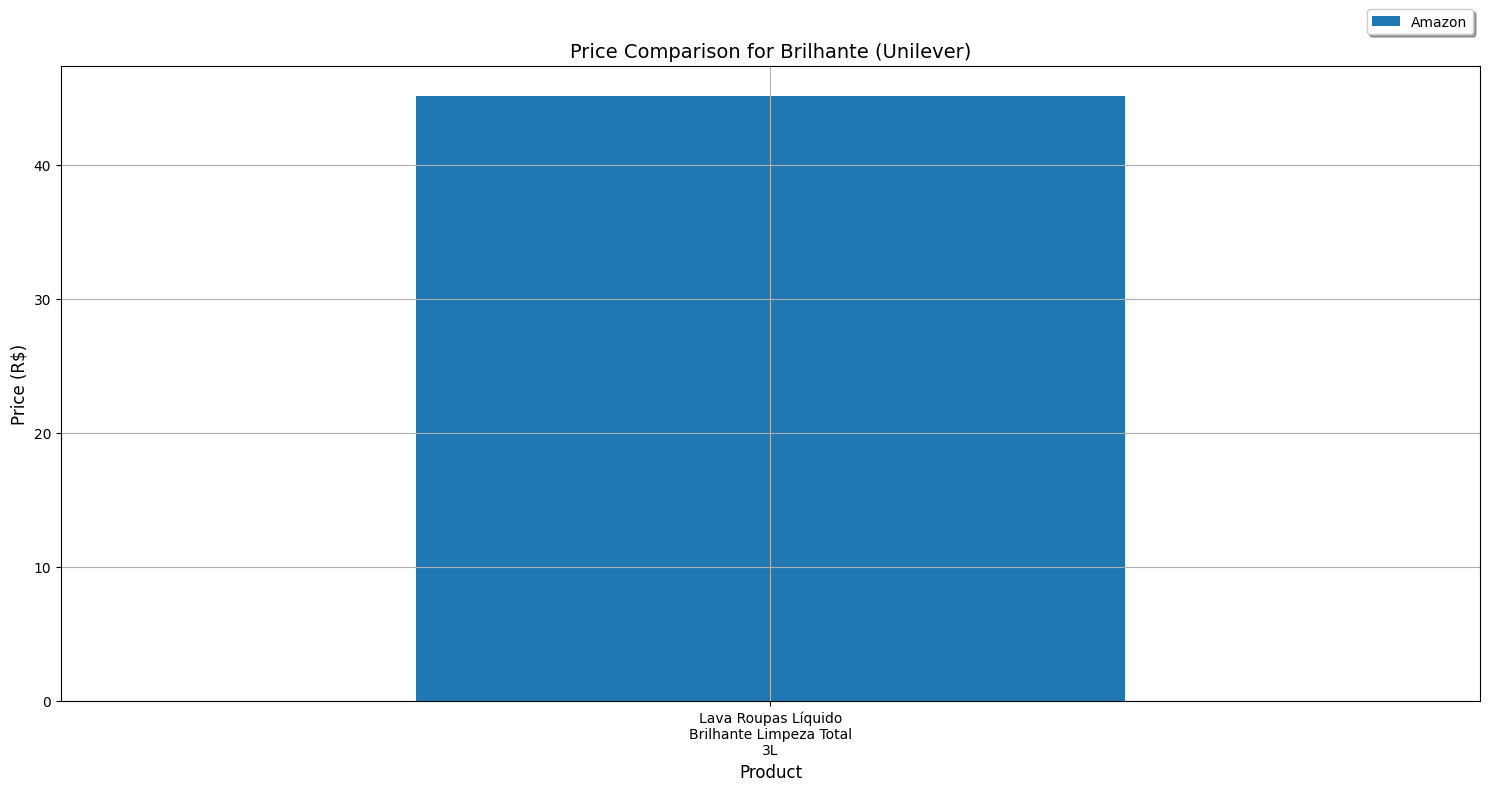

Retailer                                            Amazon  DrogaRaia  \
Product                                                                 
Shampoo Anticaspa Clear Men Limpeza Diária 2 em...   40.33      46.75   
Shampoo Anticaspa Clear Sports Men Limpeza Prof...   39.26      49.24   

Retailer                                            Mercado Livre  
Product                                                            
Shampoo Anticaspa Clear Men Limpeza Diária 2 em...          38.43  
Shampoo Anticaspa Clear Sports Men Limpeza Prof...          38.46  


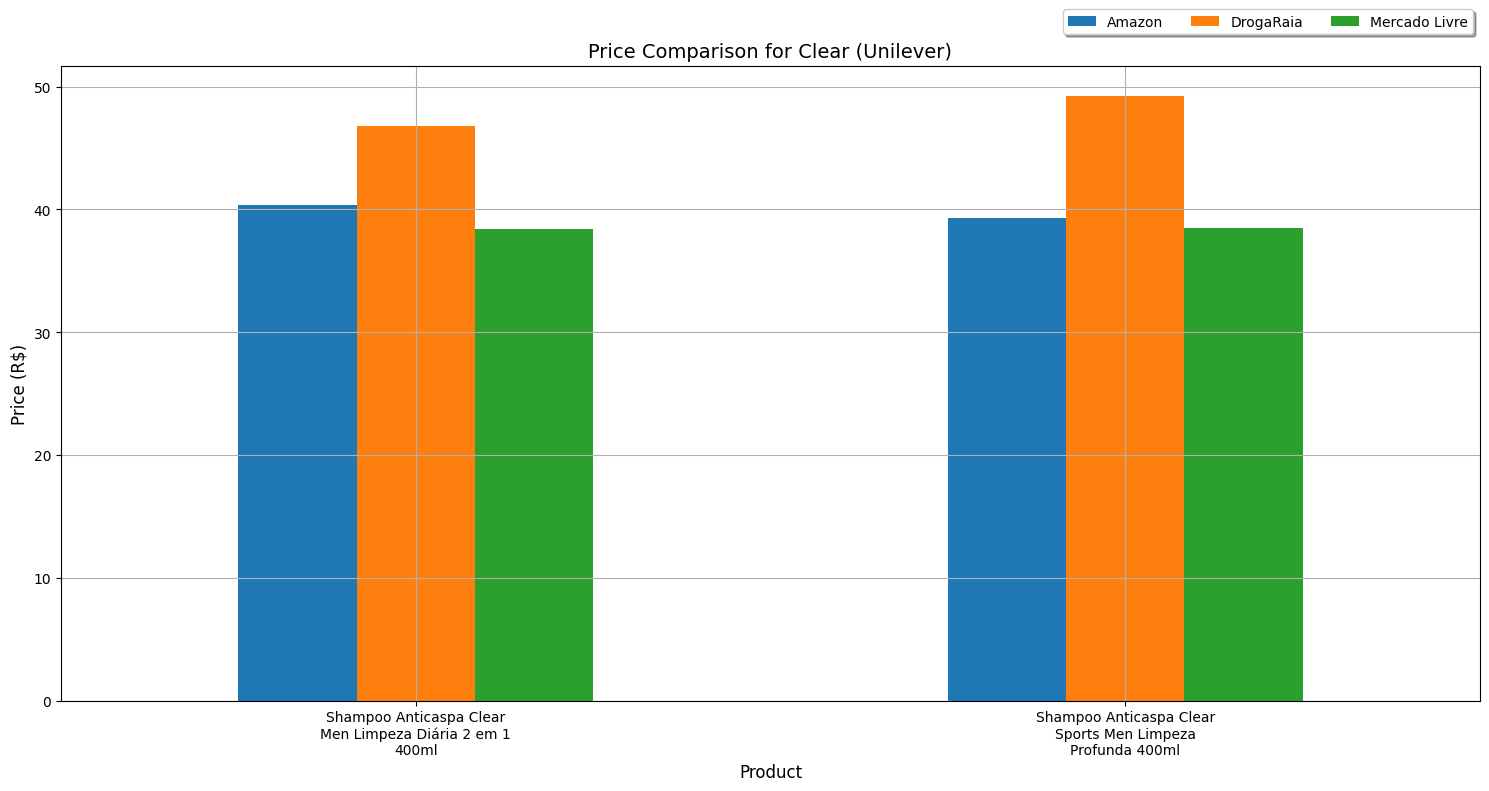

Retailer                               Amazon  DrogaRaia
Product                                                 
Creme Dental Closeup Triple Menta 70g    2.65       6.94


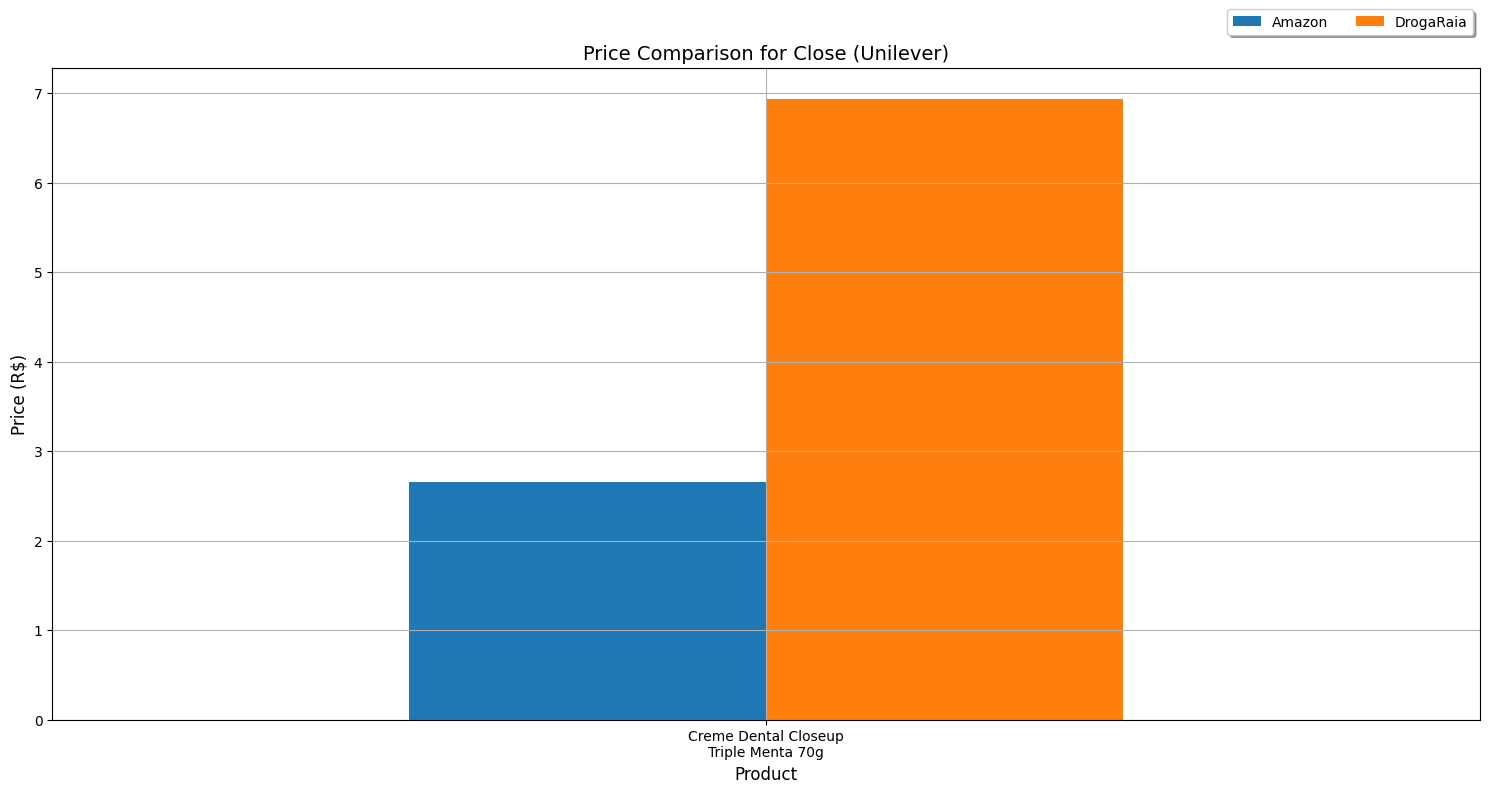

Retailer                                 Amazon  DrogaRaia
Product                                                   
Gel Dental Close Up Liquifresh Ice 100g    9.27       7.88


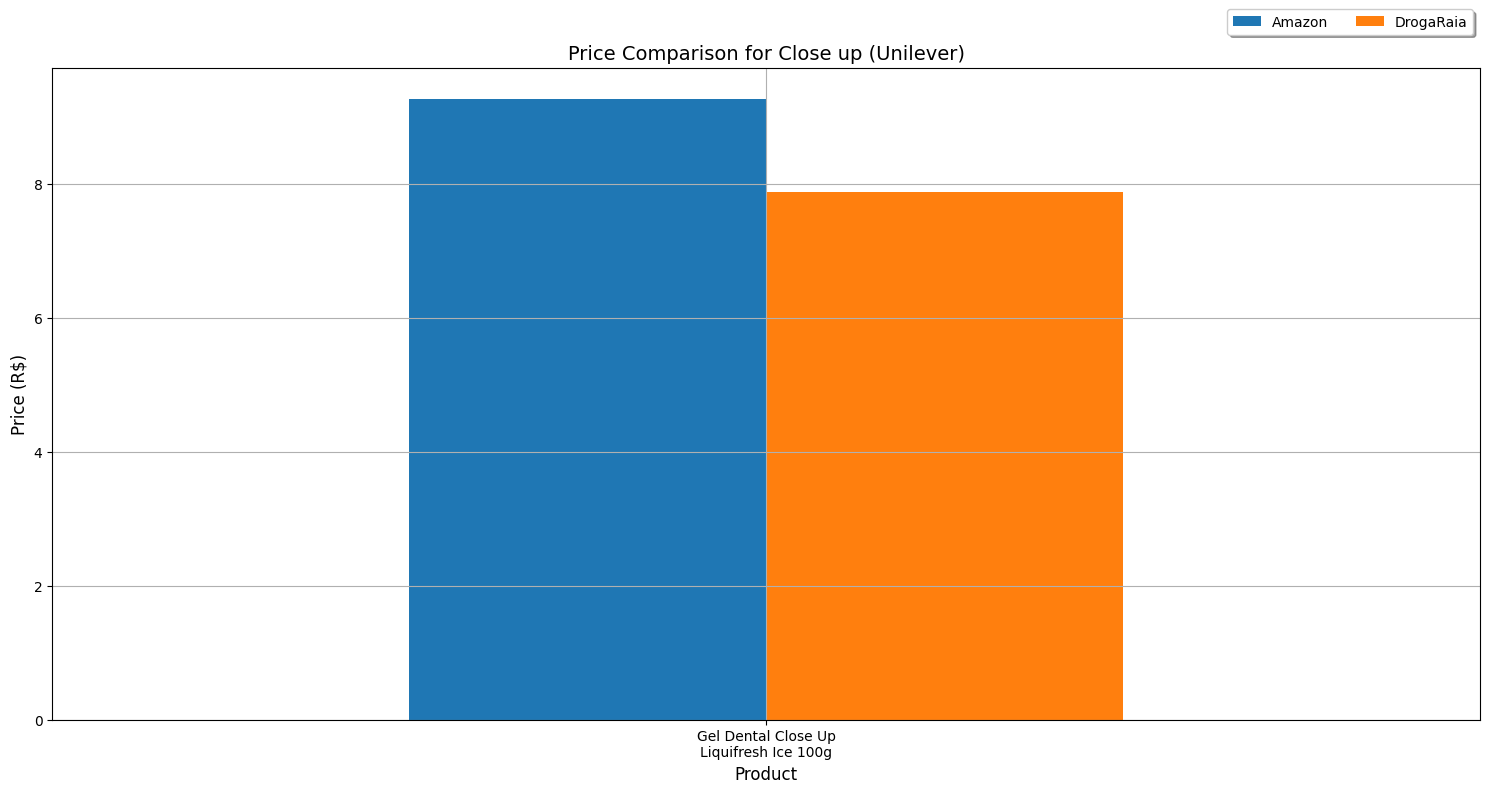

Retailer                                            Amazon
Product                                                   
Amaciante Comfort Pro Lavanderia Profissional 10L    74.51
Amaciante Concentrado  Comfort Brisa Elegante 1 L    34.59
Amaciante Concentrado Comfort Frescor Intenso 5...   21.68
Amaciante Concentrado Comfort Puro Cuidado 1 L       35.13


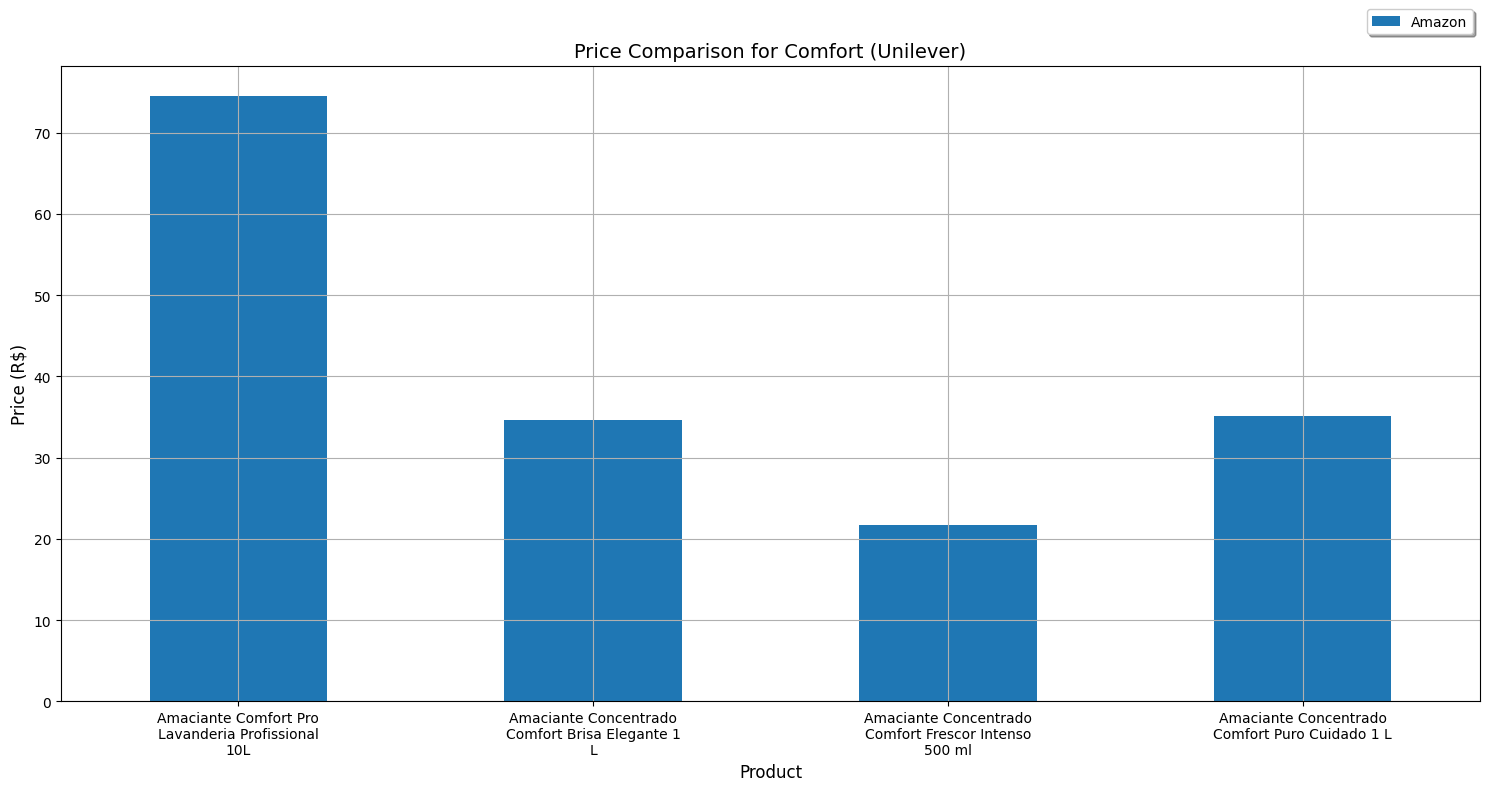

Retailer                                        Amazon  DrogaRaia  \
Product                                                             
Sabonete em Barra Dove Original 90g 6 unidades   43.81      26.84   

Retailer                                        Mercado Livre  
Product                                                        
Sabonete em Barra Dove Original 90g 6 unidades          41.92  


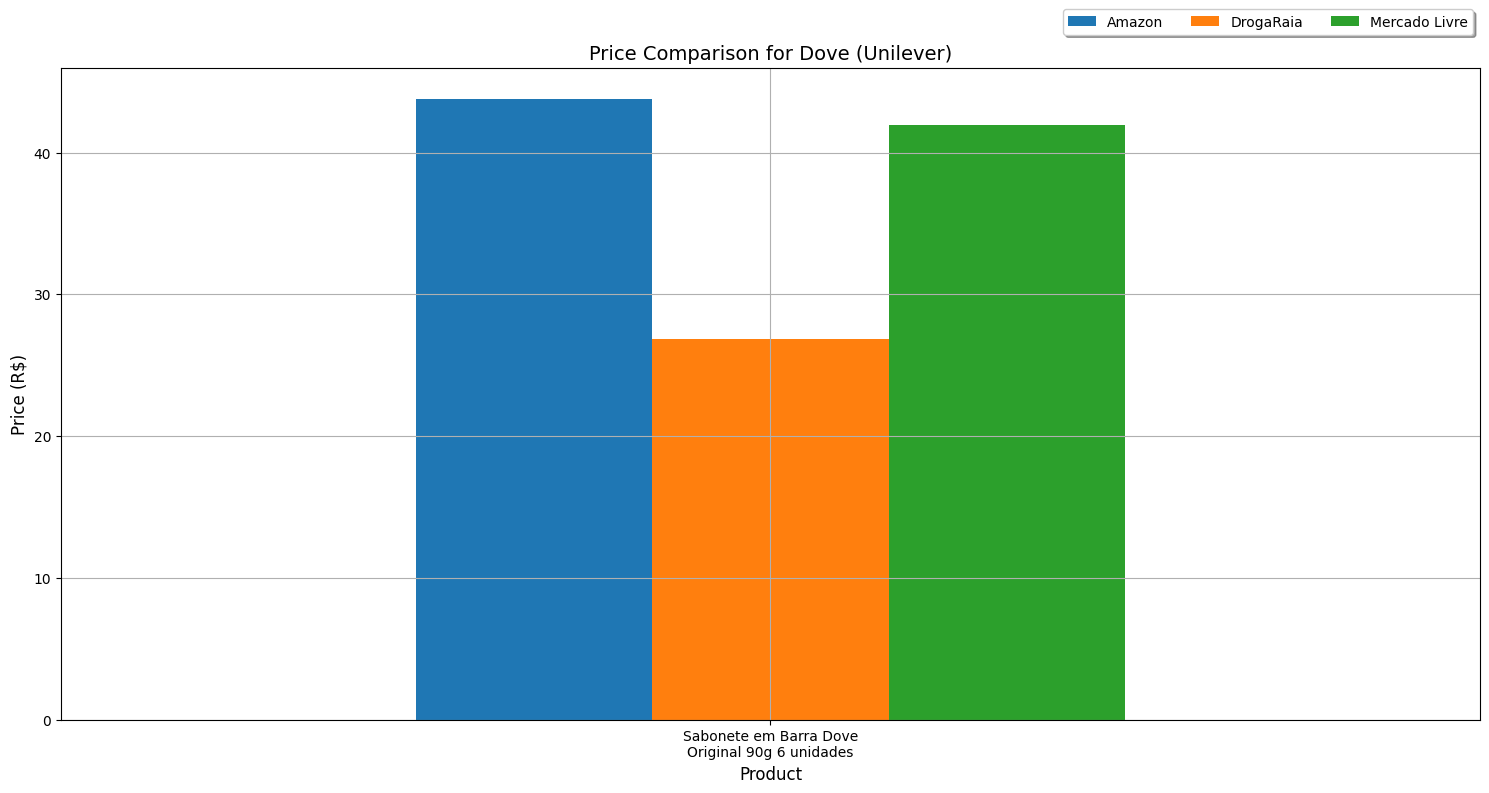

Retailer                                            Amazon  DrogaRaia
Product                                                              
Condicionador de Glicerina Baby Dove Hidratação...   14.45      34.45
Refil Sabonete Líquido Baby Dove Hidratação Enr...   15.87      21.46
Sabonete Líquido Baby Dove Hidratação Glicerina...   28.83      24.96
Shampoo Baby Dove Hidratação Enriquecida 400ml       23.11      32.75
Shampoo de Glicerina Baby Dove Hidratação Glice...   18.65      19.24


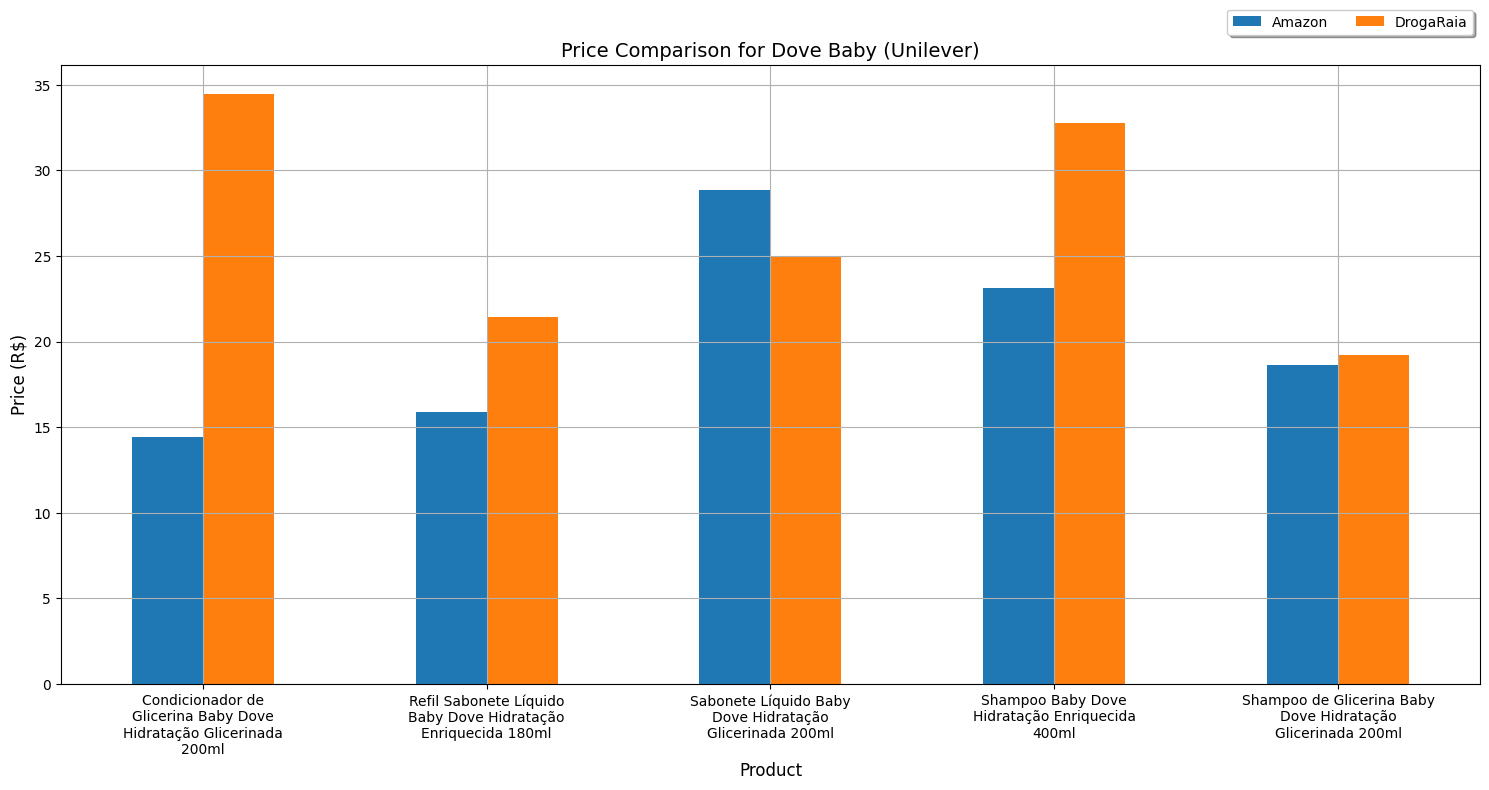

Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []
Retailer                                            Amazon  DrogaRaia
Product                                                              
Condicionador Love Beauty And Planet Energizing...   33.26      47.66
Shampoo Love Beauty And Planet Energizing Detox...   26.98      48.85


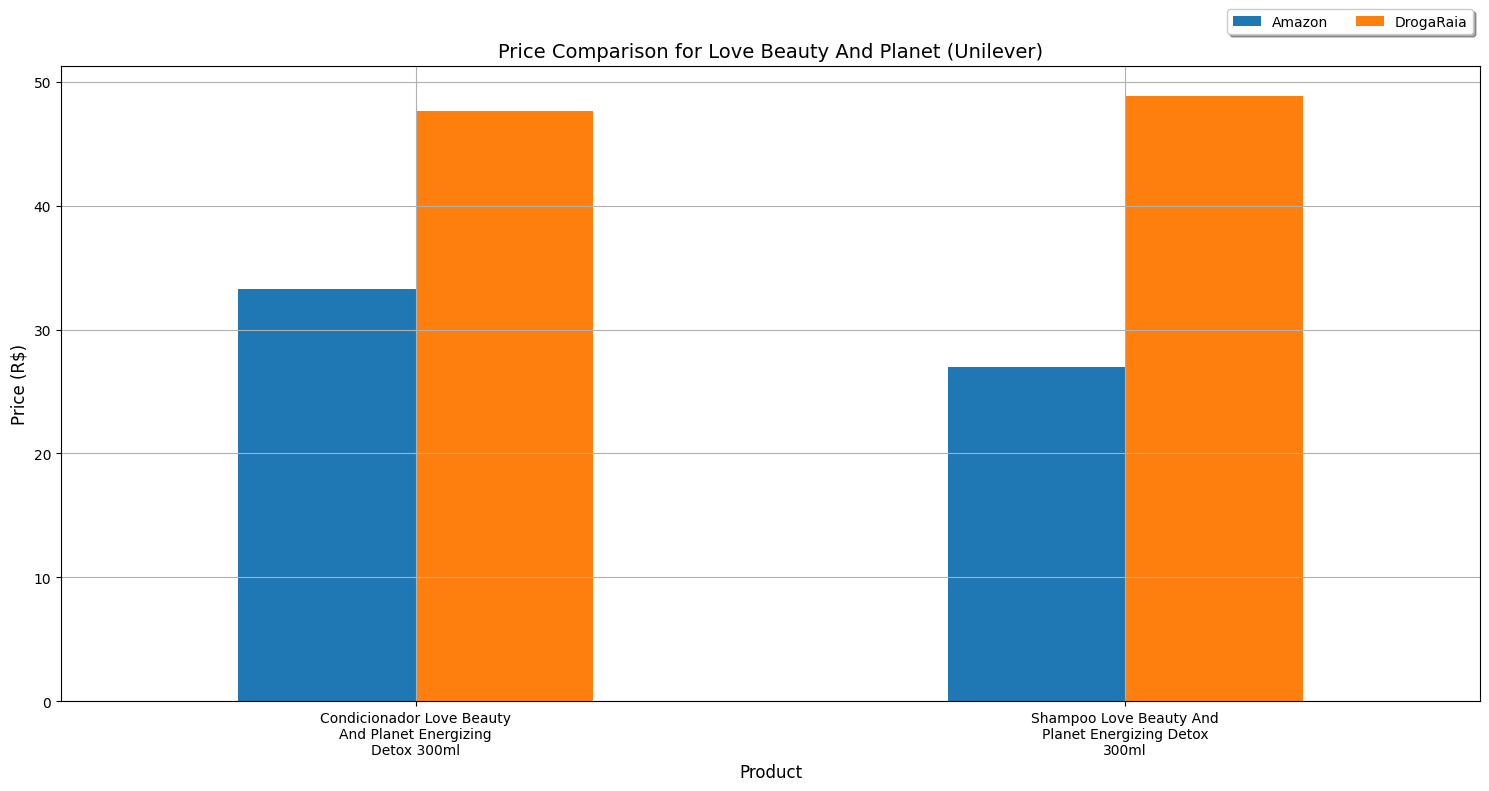

Retailer                                            Amazon  DrogaRaia
Product                                                              
Sabonete em barra Lux Buque de Jasmim 85g 4 uni...    4.39      10.19


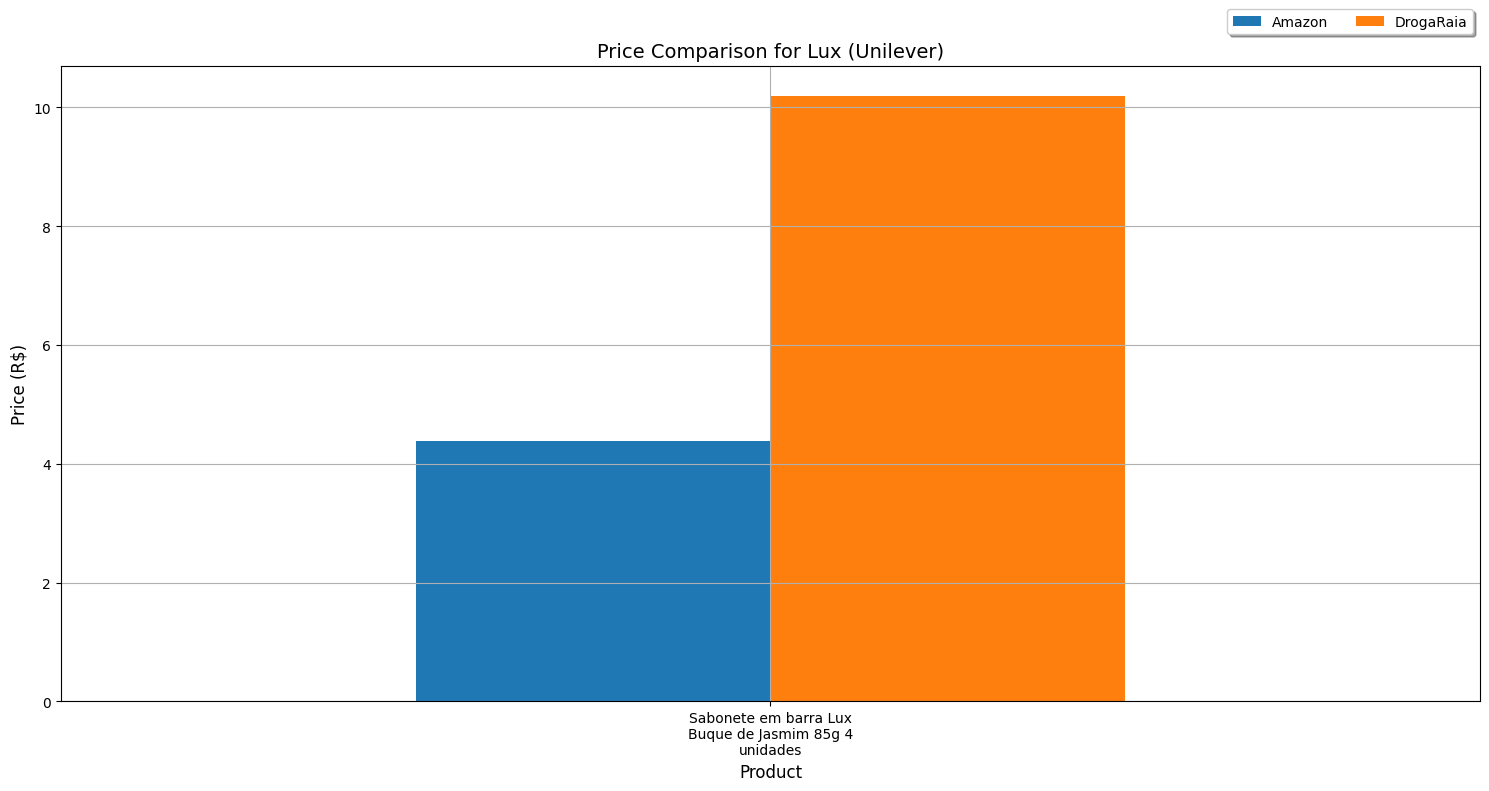

Empty DataFrame
Columns: []
Index: []
Retailer                                  DrogaRaia
Product                                            
Snack Saudável Mãe Terra Remix Cacau 25g       8.21


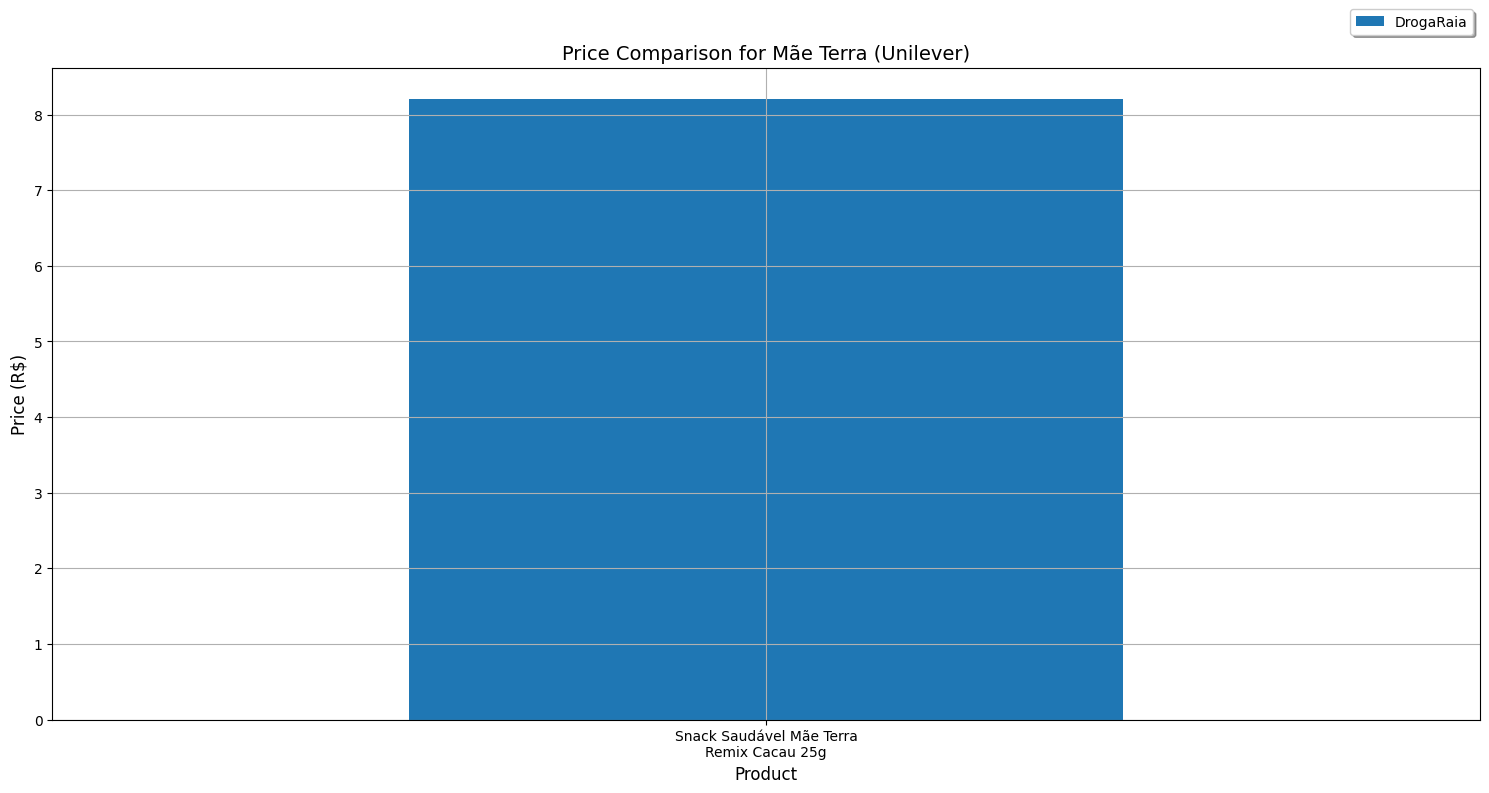

Retailer                                            DrogaRaia
Product                                                      
Condicionador Nexxus Keraphix Queratina e Arroz...      51.73
Shampoo Nexxus Keraphix Queratina e Arroz Negro...      55.80


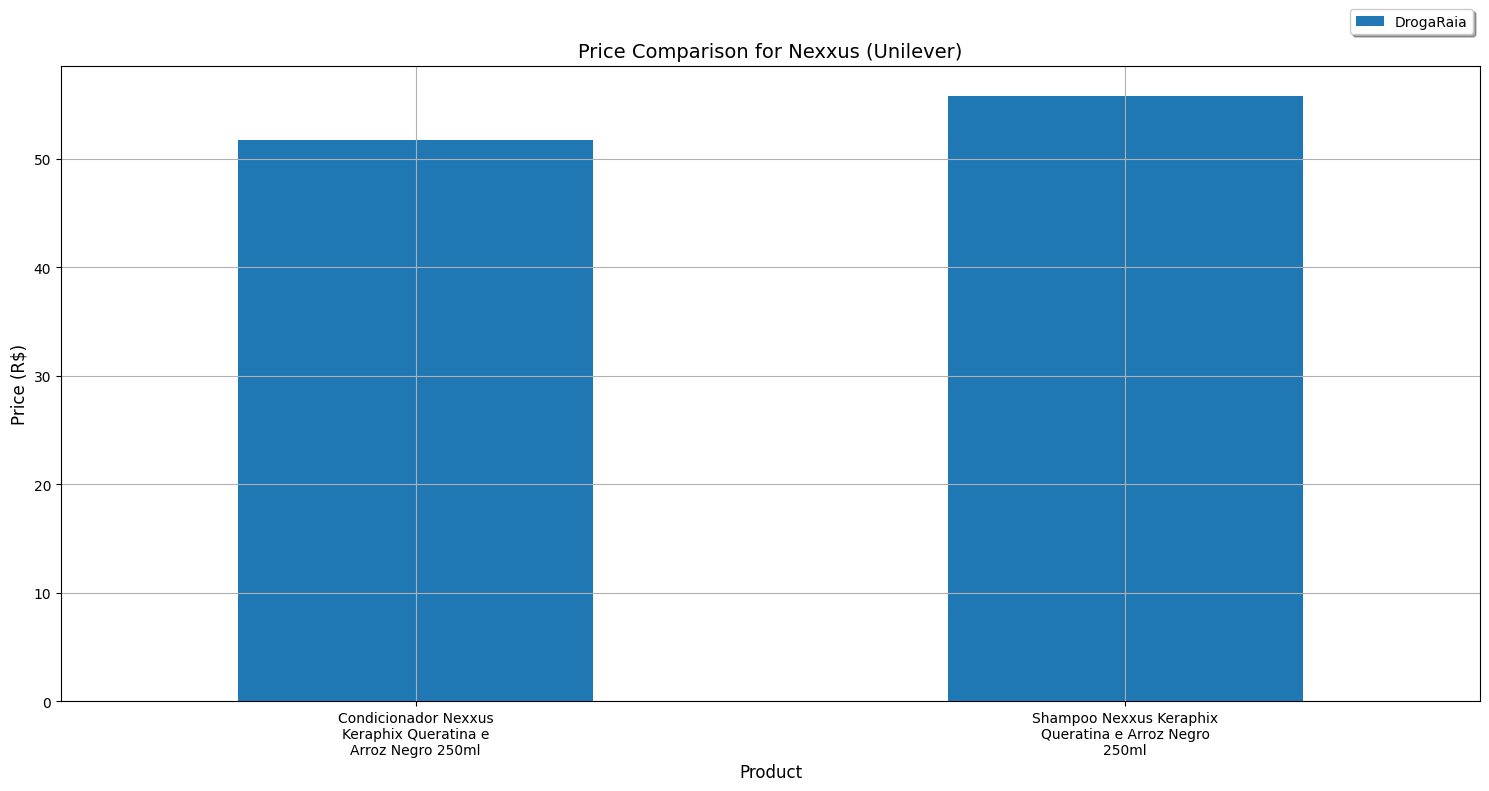

Retailer                               Amazon  Mercado Livre
Product                                                     
Sabão Líquido Omo Lavagem Perfeita 5L   63.68          75.12


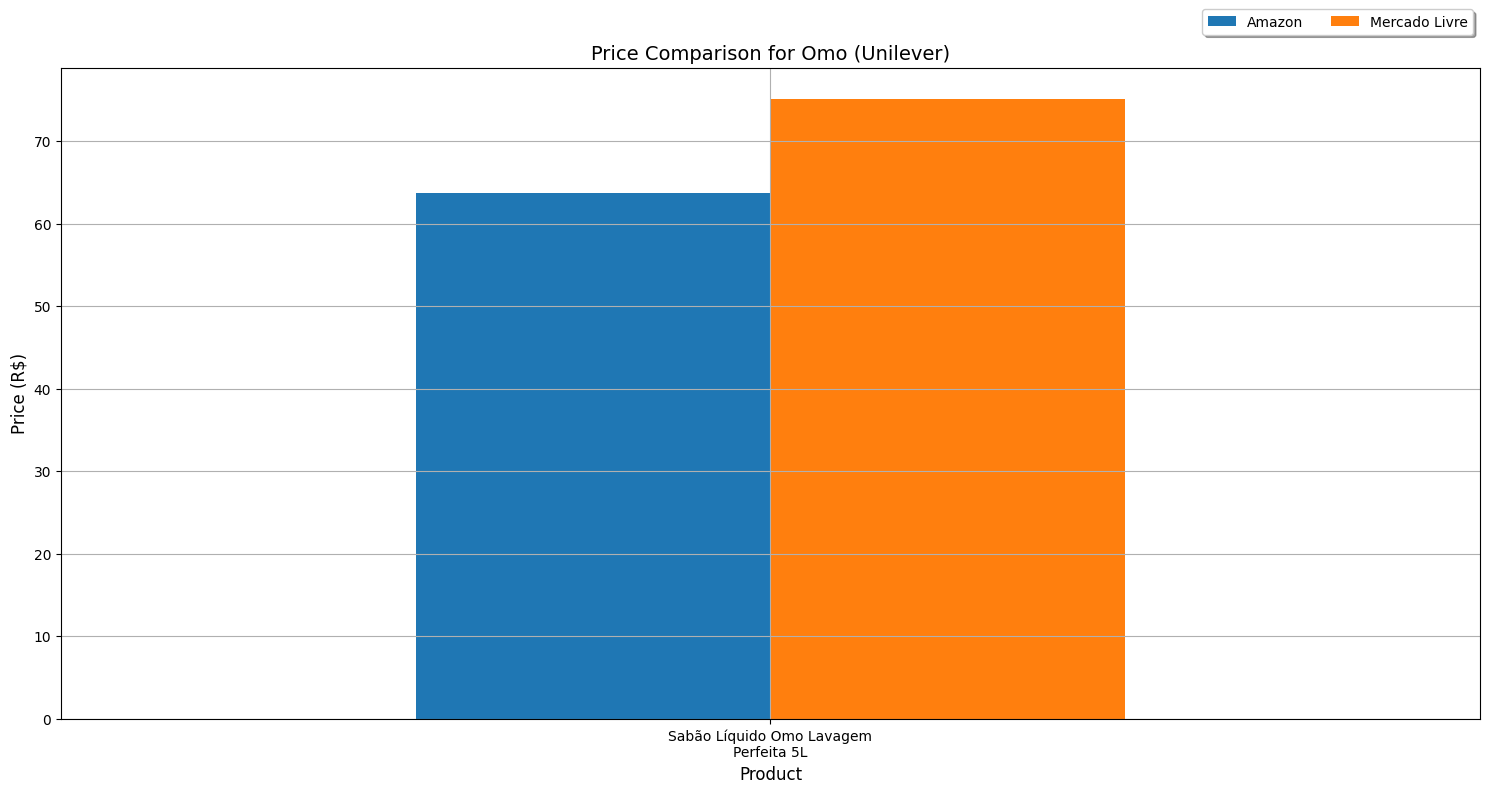

Retailer                                            Amazon  DrogaRaia  \
Product                                                                 
Sabonete em Barra Rexona Antibacterial Limpeza ...    4.33       2.64   

Retailer                                            Mercado Livre  
Product                                                            
Sabonete em Barra Rexona Antibacterial Limpeza ...           2.74  


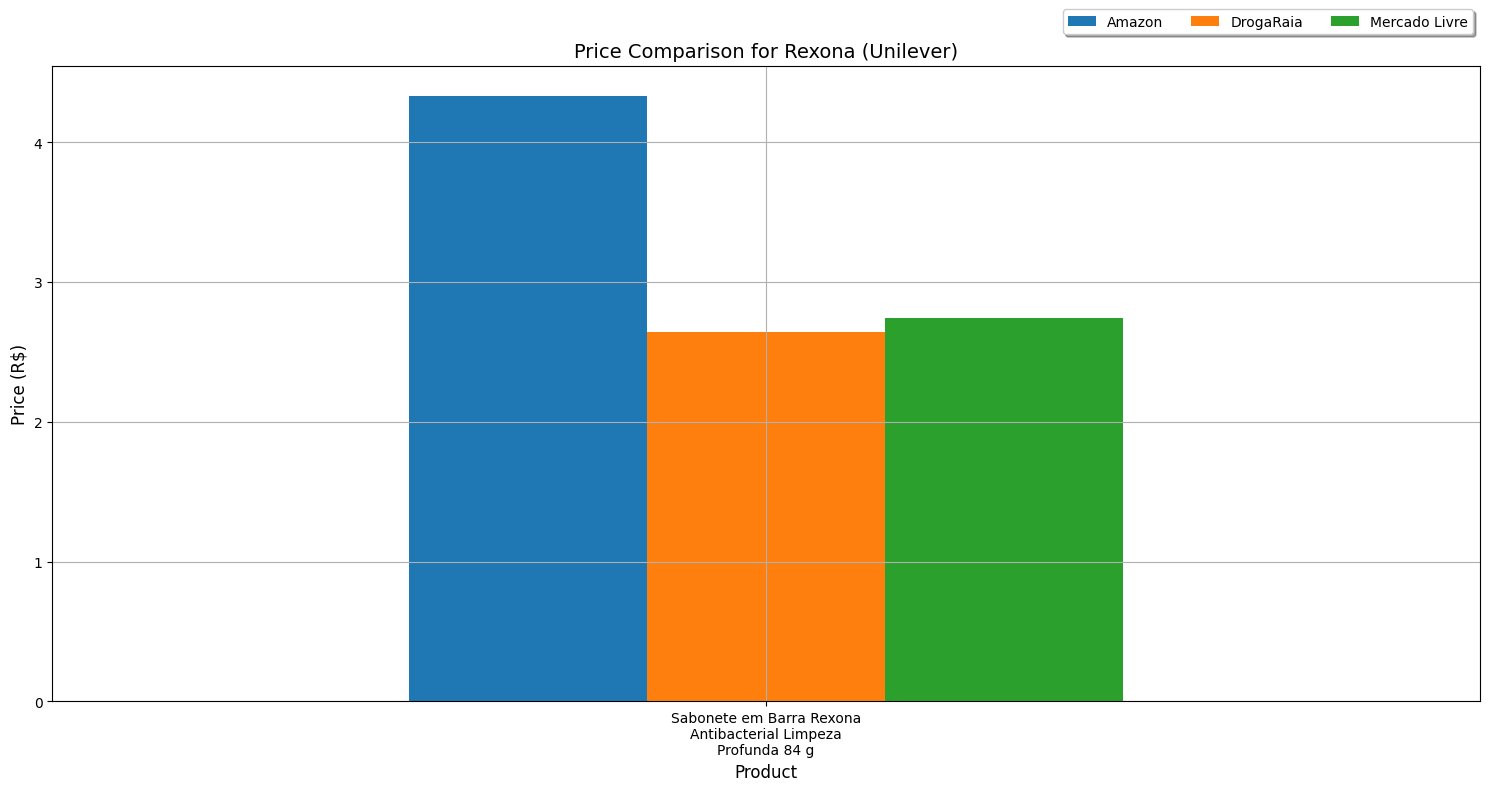

Retailer                                            Amazon  DrogaRaia
Product                                                              
Shampoo Seda By Niina Secrets Água Micelar + Hi...   15.83      15.99
Shampoo Seda By Rayza Babosa + Óleos 325ml           14.71      14.92
Shampoo Seda Ceramidas 325ml                         11.60      13.78
Tratamento Condicionador Seda Ceramidas 325ml        19.85      19.26


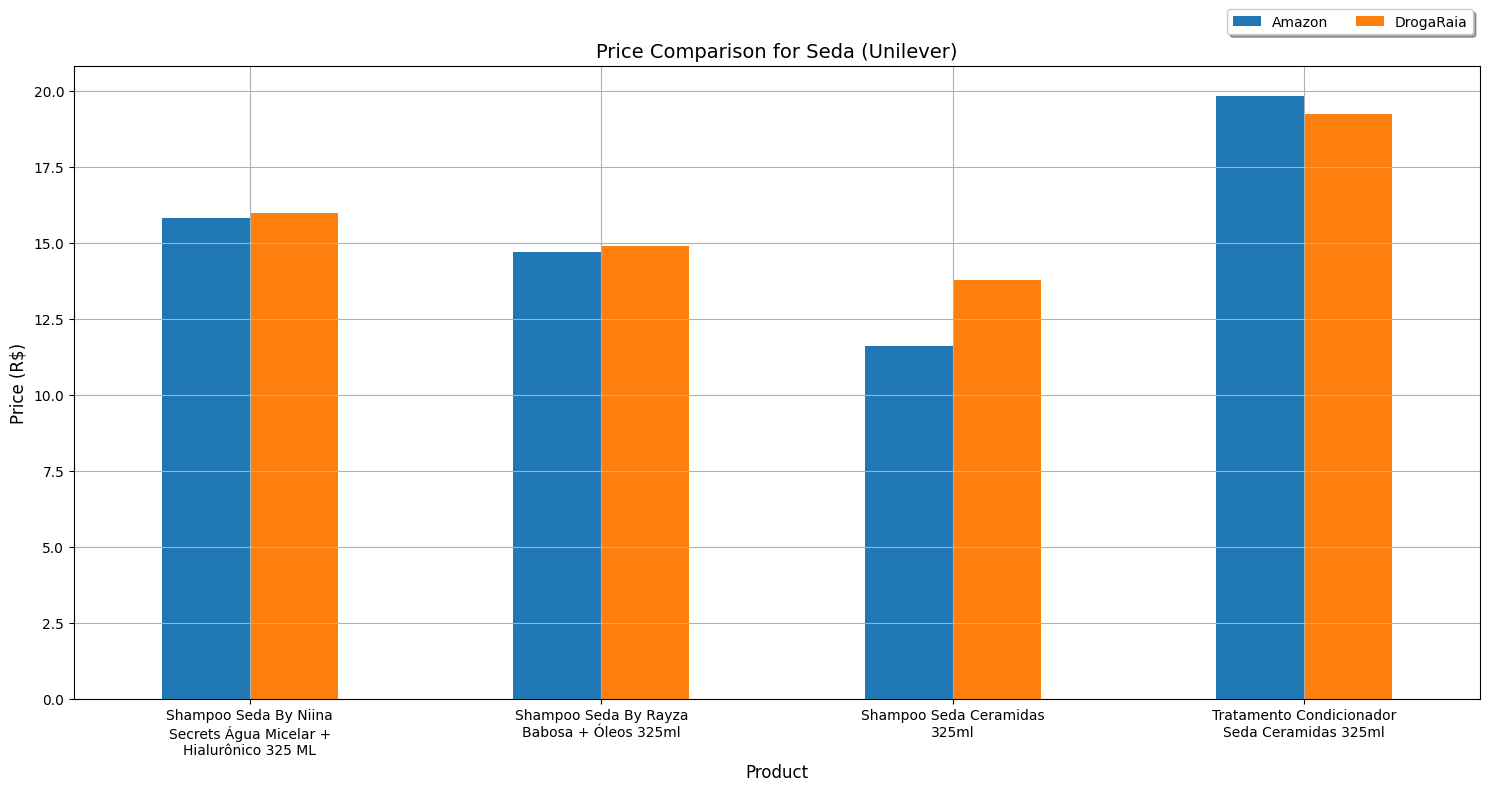

Retailer                                            Amazon  DrogaRaia
Product                                                              
Condicionador TRESemmé Hidratação Profunda 400ml     26.02      30.24
Condicionador TRESemmé Reconstrução e Força 400ml    33.69      30.33
Shampoo TRESemmé Detox Capilar 400 ml                13.92      25.60
Shampoo TRESemmé Reconstrução e Força cabelos m...   14.40      30.98


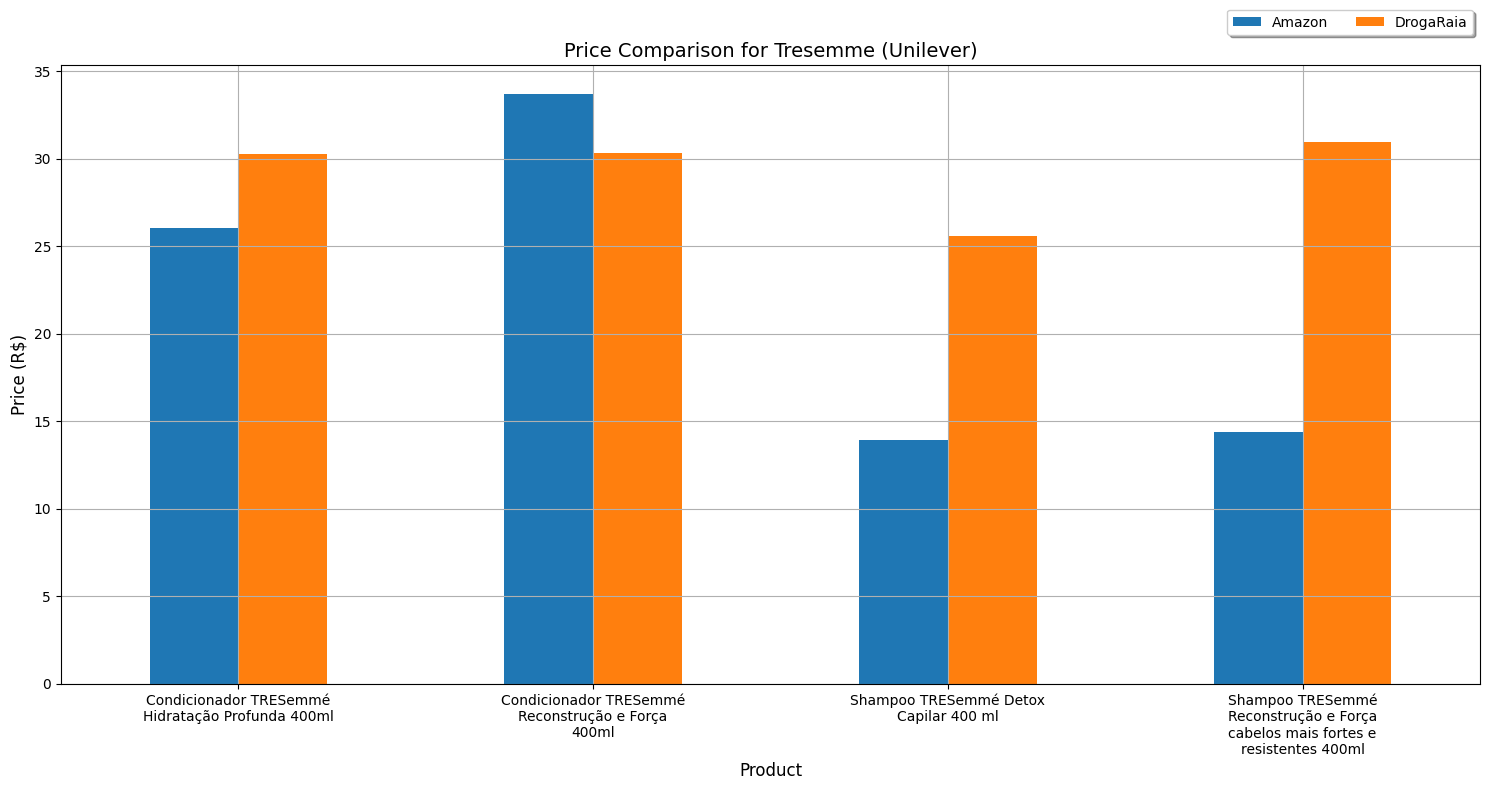

Empty DataFrame
Columns: []
Index: []
Retailer                      Amazon  Mercado Livre
Product                                            
Cloro Gel Vim Lavanda 700ml    12.72          16.87
Cloro Gel Vim Original 700ml   12.72          20.21


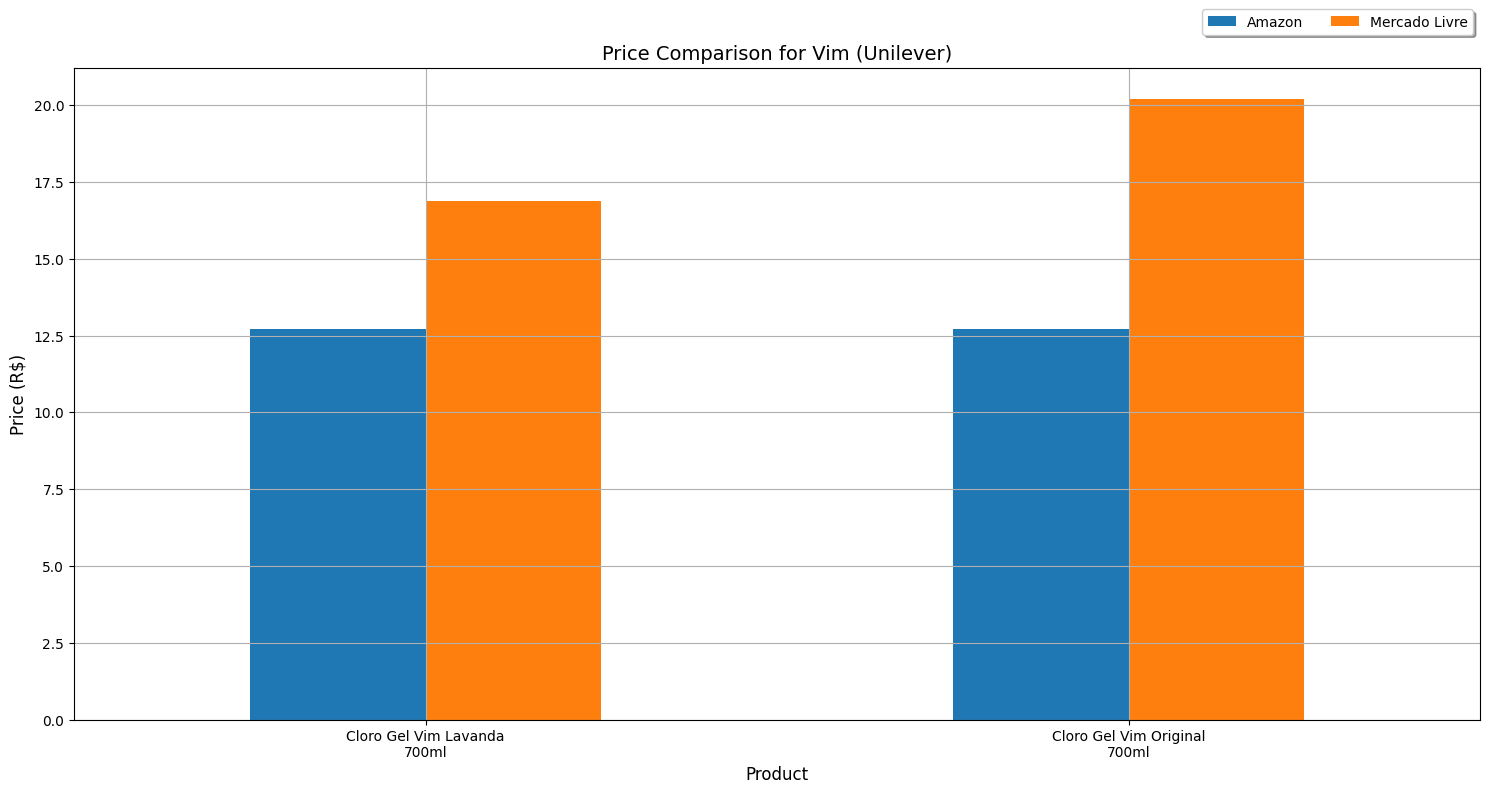

In [4]:
# Customer Price Analysis
selected_customer = 'Unilever'
selected_retailer = ['Amazon', 'DrogaRaia', 'Drogasil', 'Mercado Livre']
#selected_retailer = pd.unique()

df_join1 = df_prod.merge(right = df_coletas, how='inner',\
                    on = 'MasterKey_RetailerProduct').groupby(\
                        ["Customer","Specifics", "Competitor","Brand", "EAN", "Product", "Retailer"]\
                            ).mean()[["SuggestedPrice","FinalPrice"]]
df_join1["FinalPrice"] = np.round(df_join1["FinalPrice"].values,decimals = 2)
df_join1.reset_index(inplace = True)
df_join1

df_selected_customer = df_join1[(df_join1["Customer"] == selected_customer)&(df_join1["Competitor"] == 0)]

for brand in pd.unique(df_selected_customer["Brand"]):
    df_selected_brand = df_selected_customer[df_selected_customer["Brand"] == brand]
    
    # Group by EAN and Retailer, calculate mean price
    ean_retailer_prices = df_selected_brand.groupby(['EAN', 'Retailer','Product'])['FinalPrice'].mean().reset_index()
    ean_retailer_prices = ean_retailer_prices.merge(right = pd.DataFrame(selected_retailer, columns = ['Retailer']), how = 'inner')


    # Pivot the data for plotting
    pivot_data = ean_retailer_prices.pivot(index='Product', columns='Retailer', values='FinalPrice')
    pivot_data.dropna(inplace = True)
    
    print(pivot_data)

    if not pivot_data.empty:
        # Create a bar chart for each EAN
        #ax = pivot_data.plot(kind='bar')
        ax = pivot_data.plot(kind='bar', figsize=(15, 8))
        ax.set_xlabel('Product', fontsize=12)                                   # Xlabel font and size
        ax.set_ylabel('Price (R$)', fontsize=12)                                     # Ylabel font and size

        ax.set_title(f'Price Comparison for {brand} ({selected_customer})', fontsize=14)

        # Break xlabels into multiple lines using textwrap
        wrapped_xlabels = [textwrap.fill(label, width=25) for label in pivot_data.index]
        
        # Xlabel rotation and position 
        ax.set_xticklabels(wrapped_xlabels, rotation=0, ha='center', fontsize=10)    

        # Position the legend outside the chart
        ax.legend(loc='upper right', 
                bbox_to_anchor=(1.0, 1.1), ncol=3, 
                fancybox=True, shadow=True,fontsize=10)                      # Legend font size

        # Add grid lines to the plot
        ax.grid(True)
        
        
        plt.tight_layout()
        plt.show()

C:\Users\luiza\AppData\Local\Temp\ipykernel_7764\2325389595.py:9: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_join2 = df_prod.merge(right = df_coletas, how='inner',\
C:\Users\luiza\AppData\Local\Temp\ipykernel_7764\2325389595.py:35: FutureWarning: The default value of regex will change from True to False in a future version.
  pivot_data.columns = pivot_data.columns.str.replace(r'^[A-Za-z]+[0-9]+','')


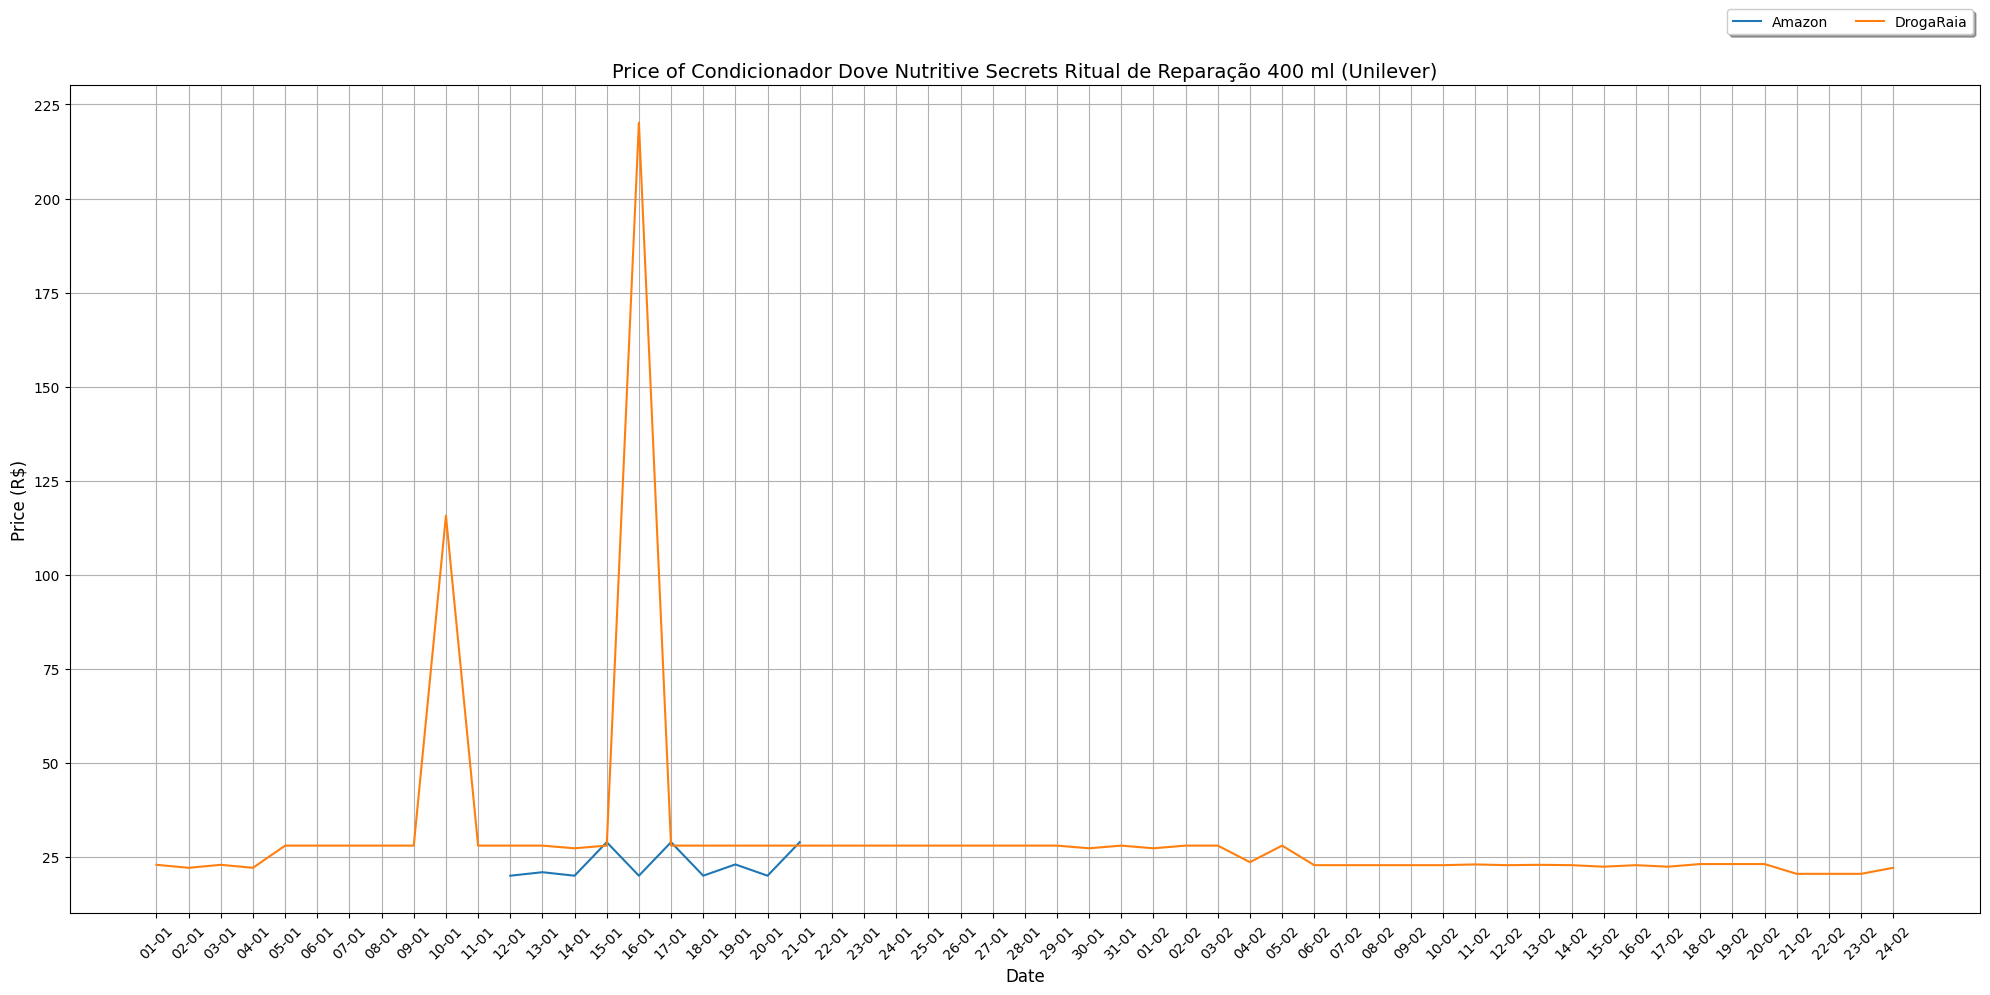

C:\Users\luiza\AppData\Local\Temp\ipykernel_7764\2325389595.py:35: FutureWarning: The default value of regex will change from True to False in a future version.
  pivot_data.columns = pivot_data.columns.str.replace(r'^[A-Za-z]+[0-9]+','')


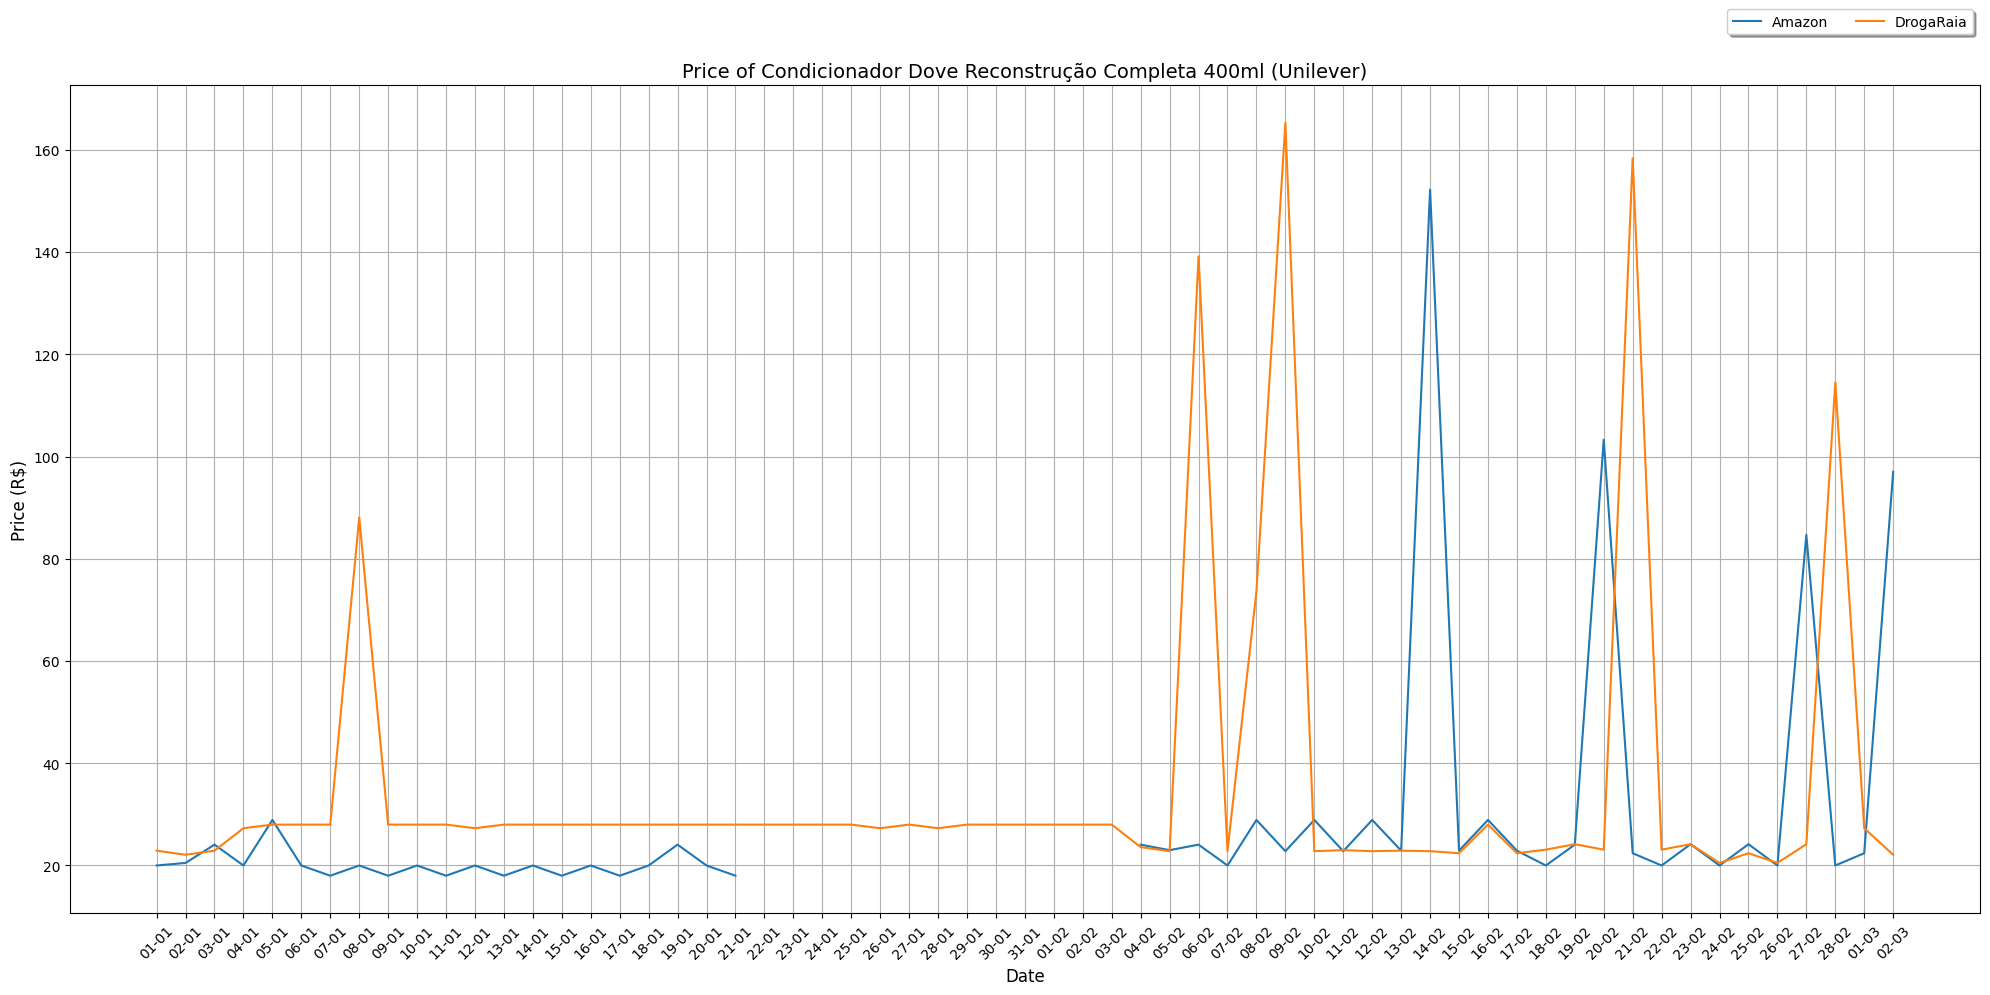

C:\Users\luiza\AppData\Local\Temp\ipykernel_7764\2325389595.py:35: FutureWarning: The default value of regex will change from True to False in a future version.
  pivot_data.columns = pivot_data.columns.str.replace(r'^[A-Za-z]+[0-9]+','')


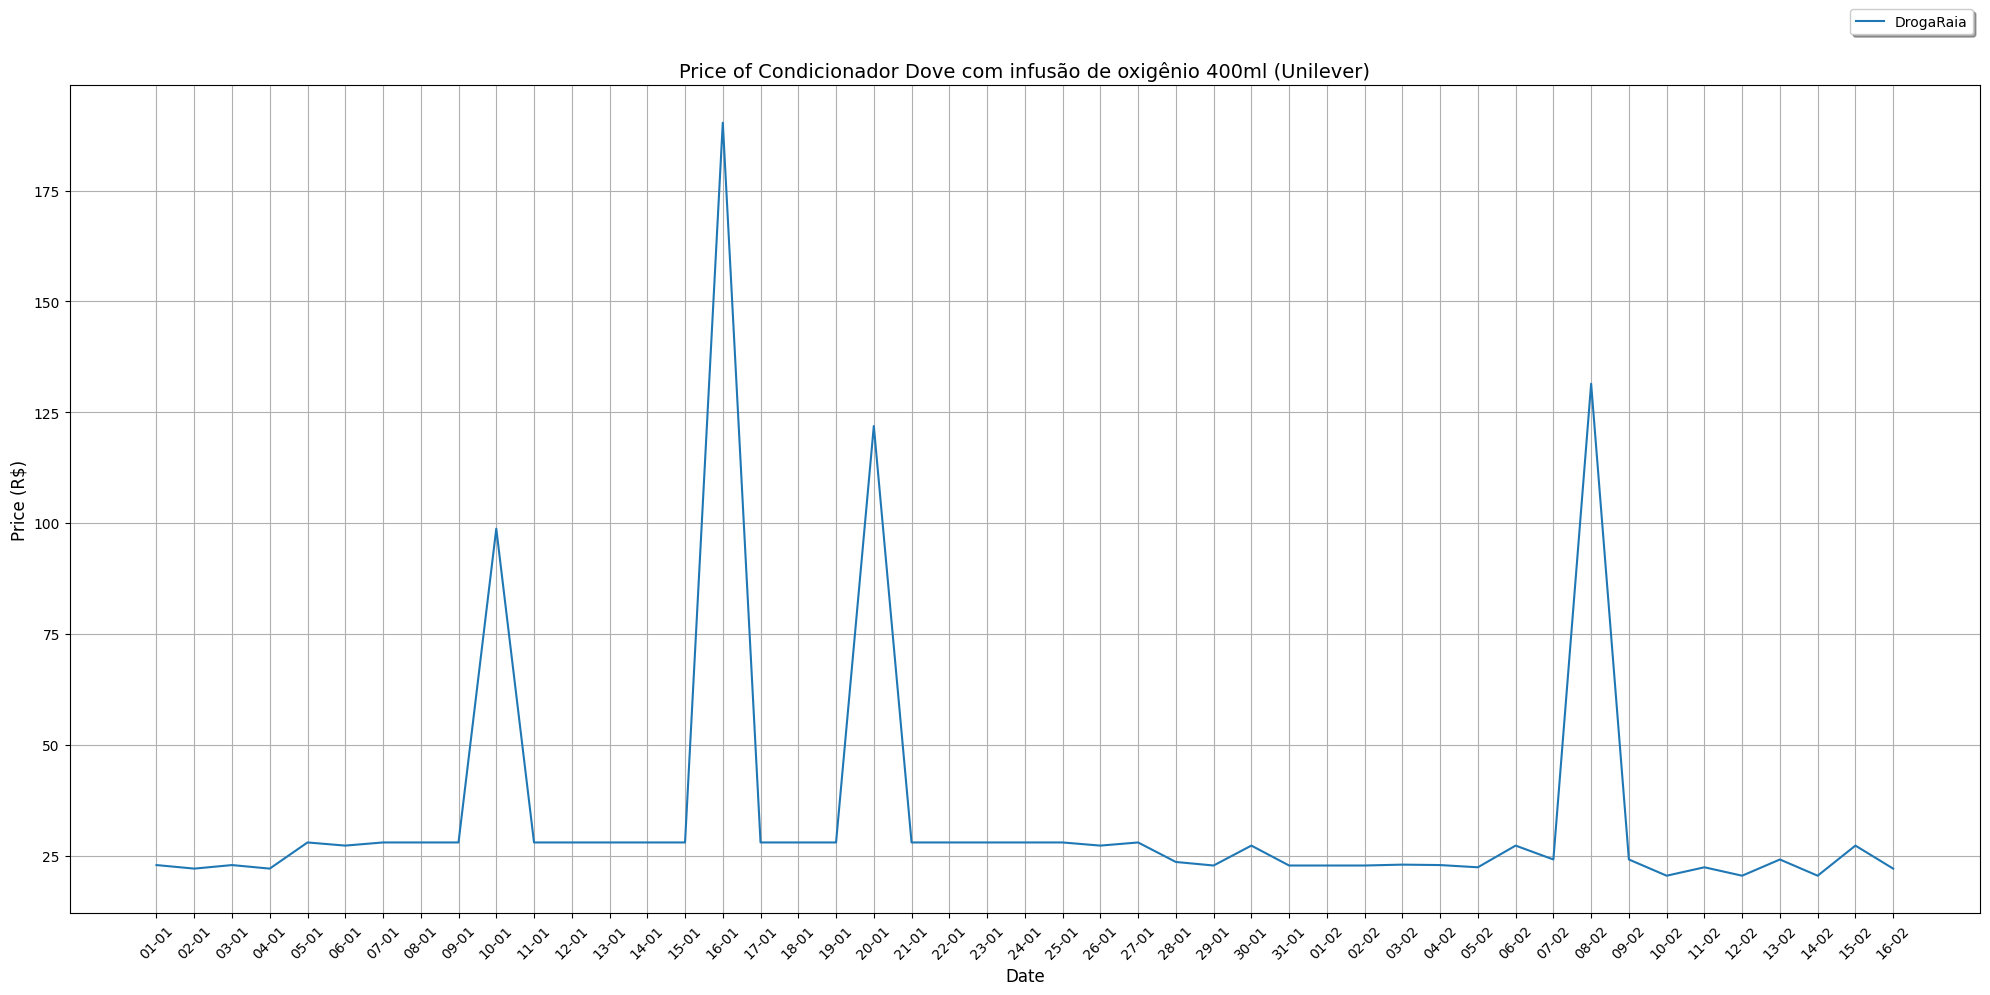

C:\Users\luiza\AppData\Local\Temp\ipykernel_7764\2325389595.py:35: FutureWarning: The default value of regex will change from True to False in a future version.
  pivot_data.columns = pivot_data.columns.str.replace(r'^[A-Za-z]+[0-9]+','')


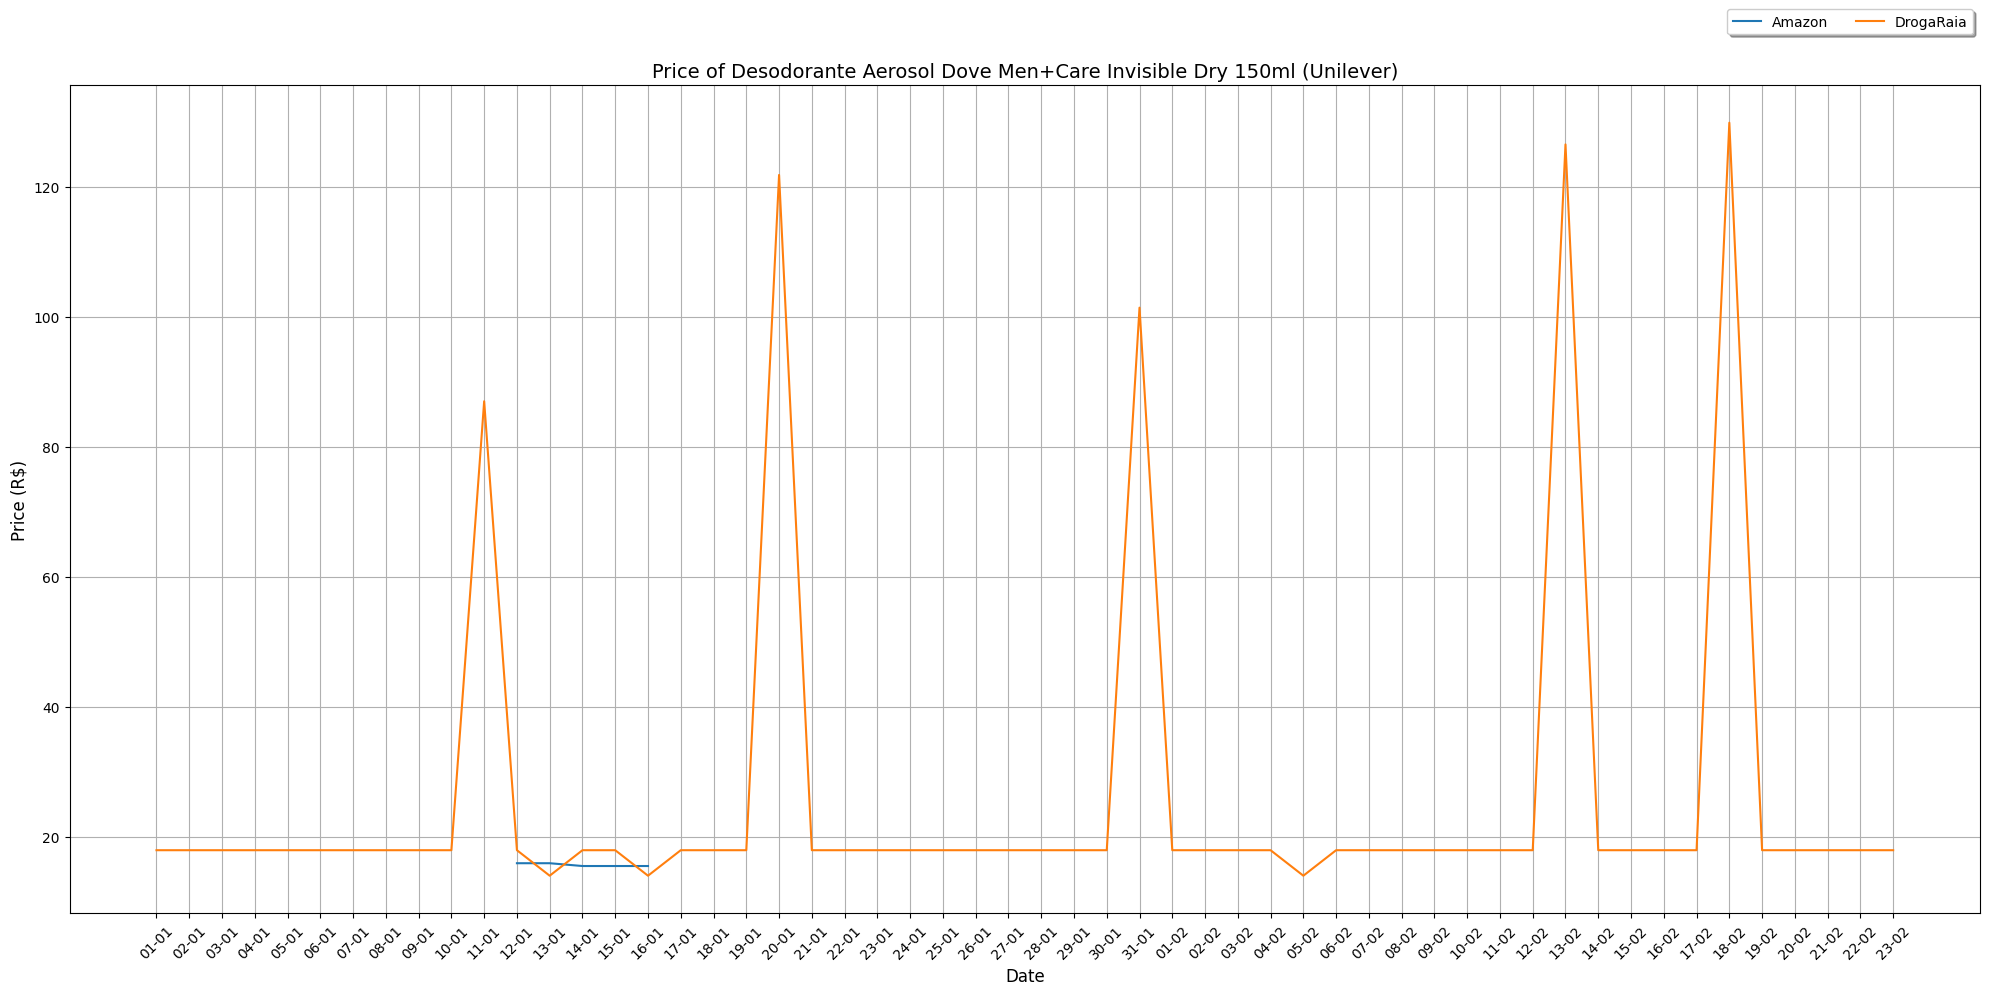

C:\Users\luiza\AppData\Local\Temp\ipykernel_7764\2325389595.py:35: FutureWarning: The default value of regex will change from True to False in a future version.
  pivot_data.columns = pivot_data.columns.str.replace(r'^[A-Za-z]+[0-9]+','')


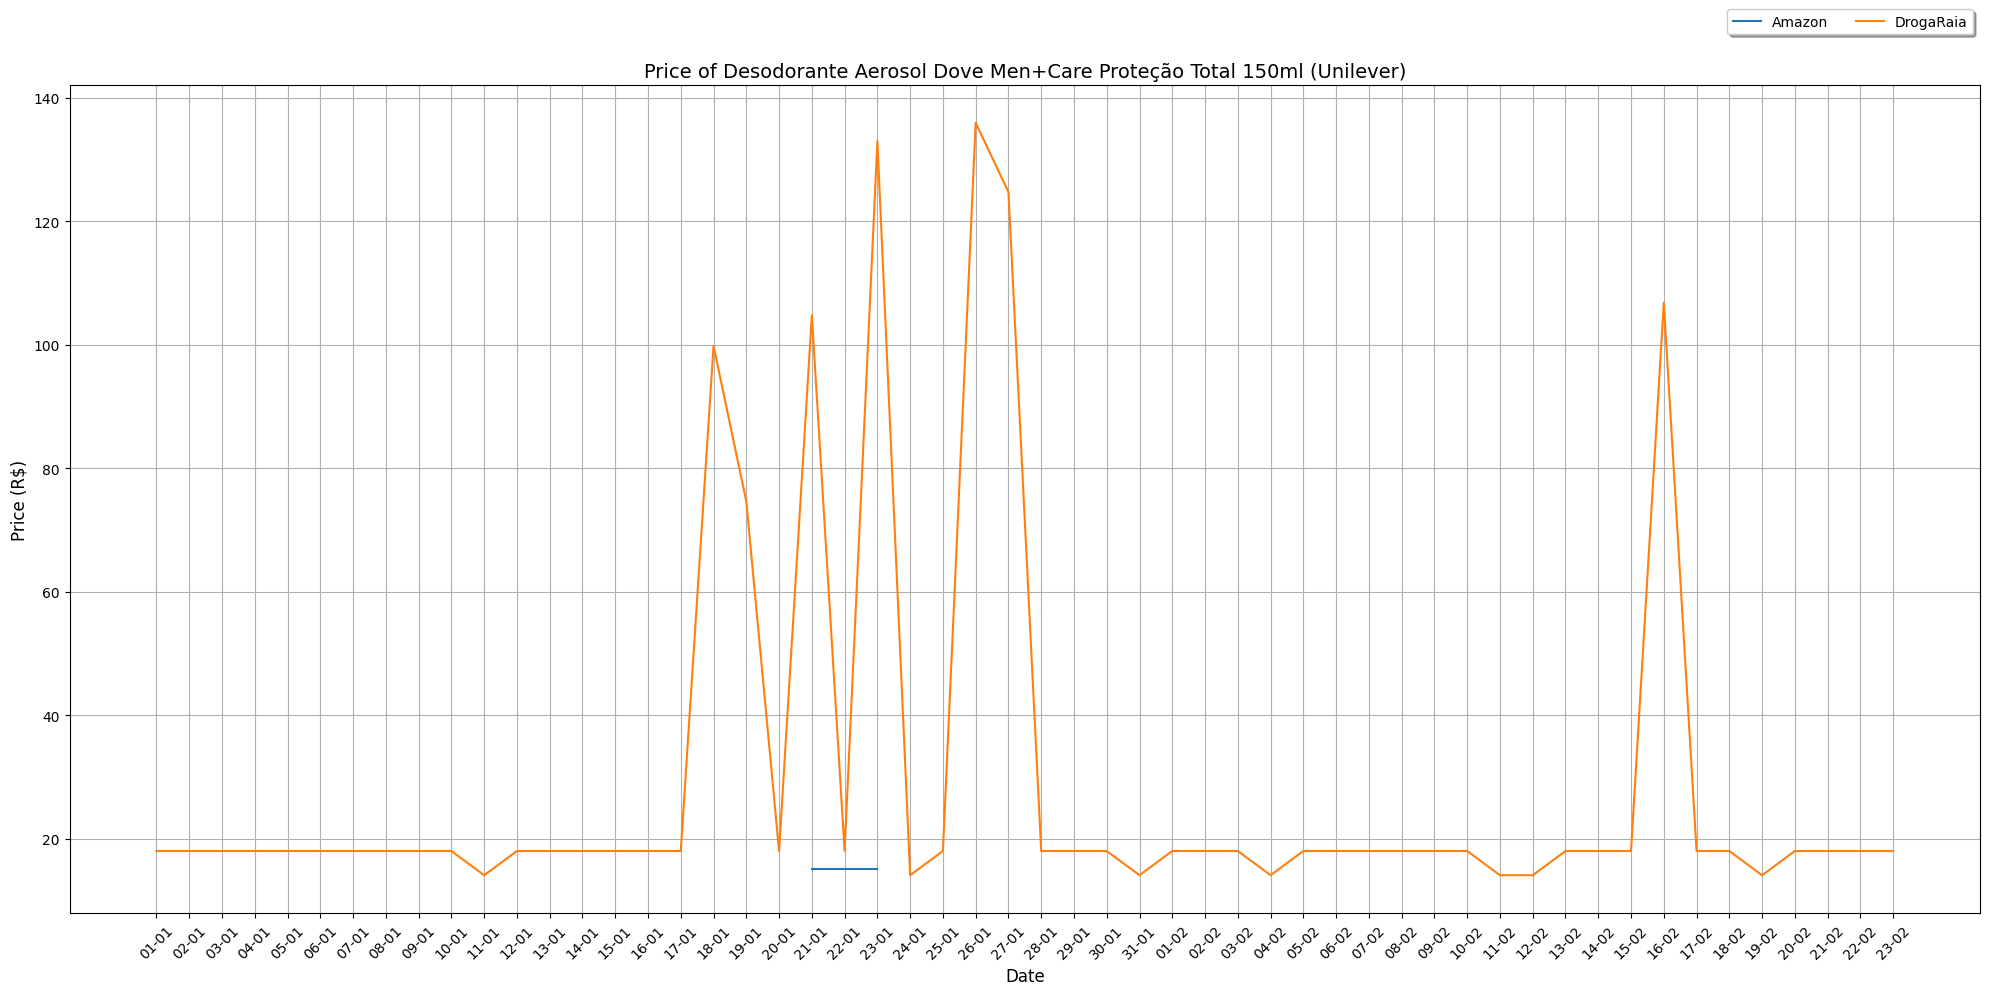

In [5]:
# Customer Price Analysis
selected_customer = 'Unilever'      #--> Customer name 
selected_brand = 'Dove'             #--> Customer associated brand 

selected_retailers = ['Amazon', 'DrogaRaia', 'Drogasil', 'Mercado Livre']   #--> Retailers to be analized 

num_ean = 5                         # --> Number of selected_brand products which prices will be analized

df_join2 = df_prod.merge(right = df_coletas, how='inner',\
                        on = 'MasterKey_RetailerProduct').groupby(\
                                                                ['Customer','Specifics', 'Competitor', 'Product',
                                                                'Brand','EAN','Retailer','MasterKey_RetailerProduct',
                                                                'DateIns'])['FinalPrice','SuggestedPrice'].mean()


df_join2['FinalPrice'] = np.round(df_join2['FinalPrice'].values,decimals = 2)
df_join2.reset_index(inplace = True)

df_selected = df_join2[(df_join2['Customer'] == selected_customer)&
                                (df_join2['Brand'] == selected_brand)&
                                (df_join2['Competitor'] == 0)]


for ean in pd.unique(df_selected['EAN'])[0:num_ean]:
    df_ean = df_selected[df_selected['EAN'] == ean]
    prod = pd.unique(df_ean['Product'].values)[0]
    
    # Group by EAN and Retailer, calculate mean price
    ean_retailer_prices = df_ean.groupby(['MasterKey_RetailerProduct', 'Retailer',
                                        'DateIns'])['FinalPrice'].mean().reset_index()
    ean_retailer_prices = ean_retailer_prices.merge(right = pd.DataFrame(selected_retailer, columns = ['Retailer']), how = 'inner')
    
    # Pivot the data for plotting
    pivot_data = ean_retailer_prices.pivot(index='DateIns', columns='MasterKey_RetailerProduct', values='FinalPrice')
    pivot_data.columns = pivot_data.columns.str.replace(r'^[A-Za-z]+[0-9]+','')

    if not pivot_data.empty:
        # Create a chart
        fig, ax = plt.subplots(figsize=(20,10))


        for retailer in pd.unique(pivot_data.columns):
            ax.plot(pivot_data.index, pivot_data[retailer], label=retailer)

        ax.set_xlabel('Date', fontsize=12)                                      # Xlabel font and size
        ax.set_ylabel('Price (R$)', fontsize=12)                                     # Ylabel font and size

        ax.set_title(f'Price of {prod} ({selected_customer})', fontsize=14)

        # xlabels datetime formatting
        date_formatter = DateFormatter('%d-%m')  # Define the desired format
        ax.xaxis.set_major_formatter(date_formatter)
        plt.xticks(rotation=45, ha='center', fontsize=10)                         # Xlabel rotation and position   

        ax.legend(loc='upper right', 
                bbox_to_anchor=(1.0, 1.1), ncol=3, 
                fancybox=True, shadow=True,fontsize=10)                      # Legend font size                                                 # Legend font size
    
        # Add grid lines to the plot
        ax.grid(True)

        plt.tight_layout()
        plt.show()


C:\Users\luiza\AppData\Local\Temp\ipykernel_7764\3525066111.py:6: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_join3 = df_prod.merge(right = df_coletas, how='inner',\


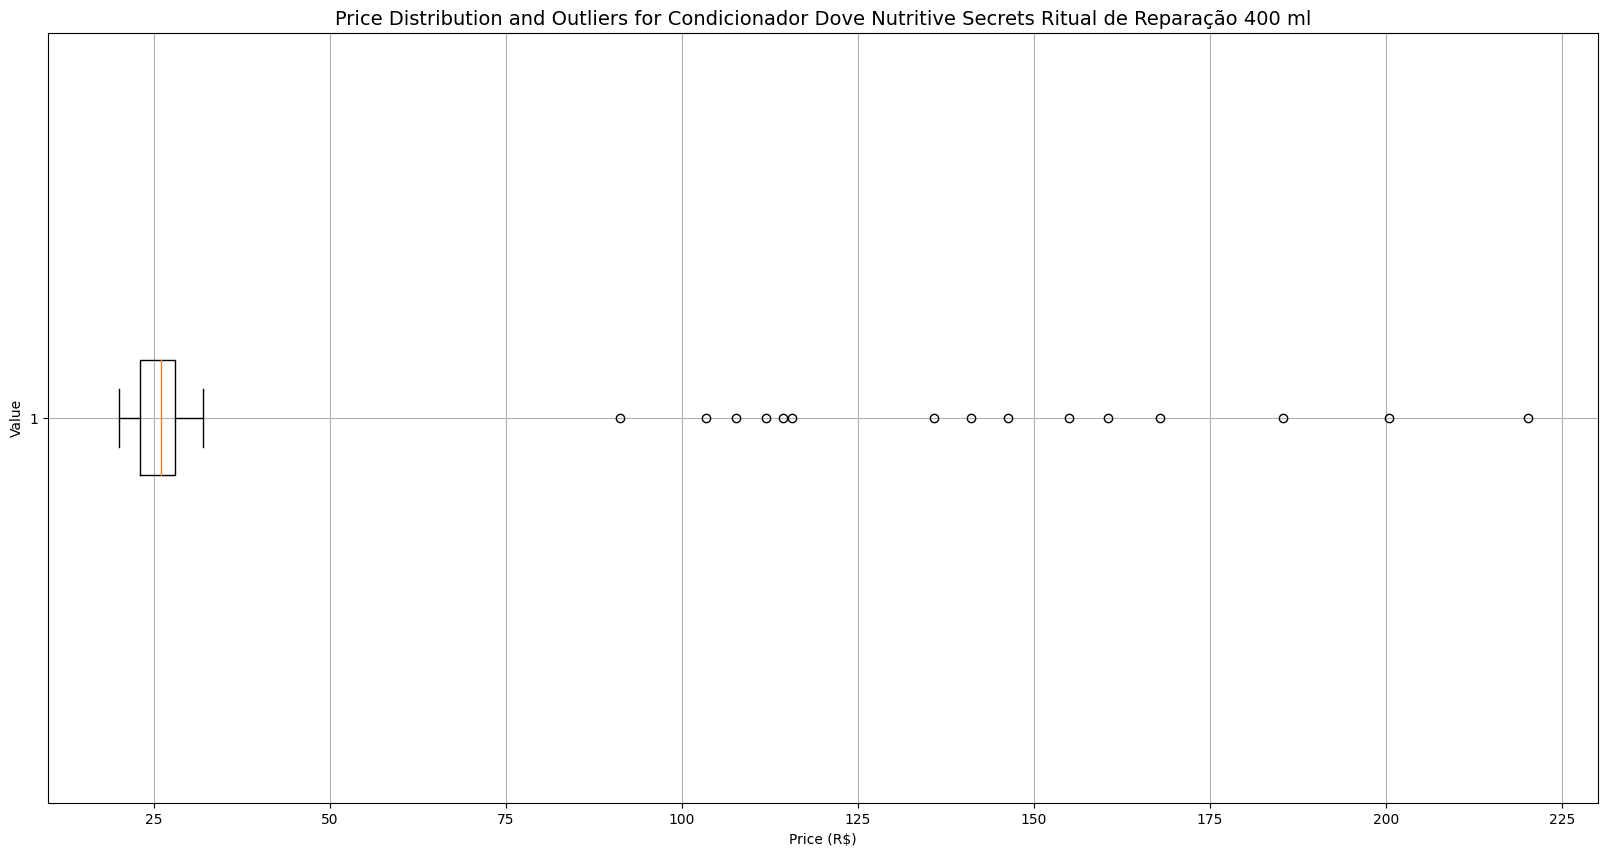

Price Descriptive Statistics (R$):
Mean: 35.04
Median: 25.99
Standard Deviation: 34.78
Min: 19.99
Max: 220.15

Outliers:
30     115.69
36     220.15
85     200.42
92     160.55
100    146.35
115    114.32
134     91.15
137    155.02
138    112.00
155    141.14
158    103.37
161    107.76
172    167.97
174    185.32
175    135.75
dtype: float64


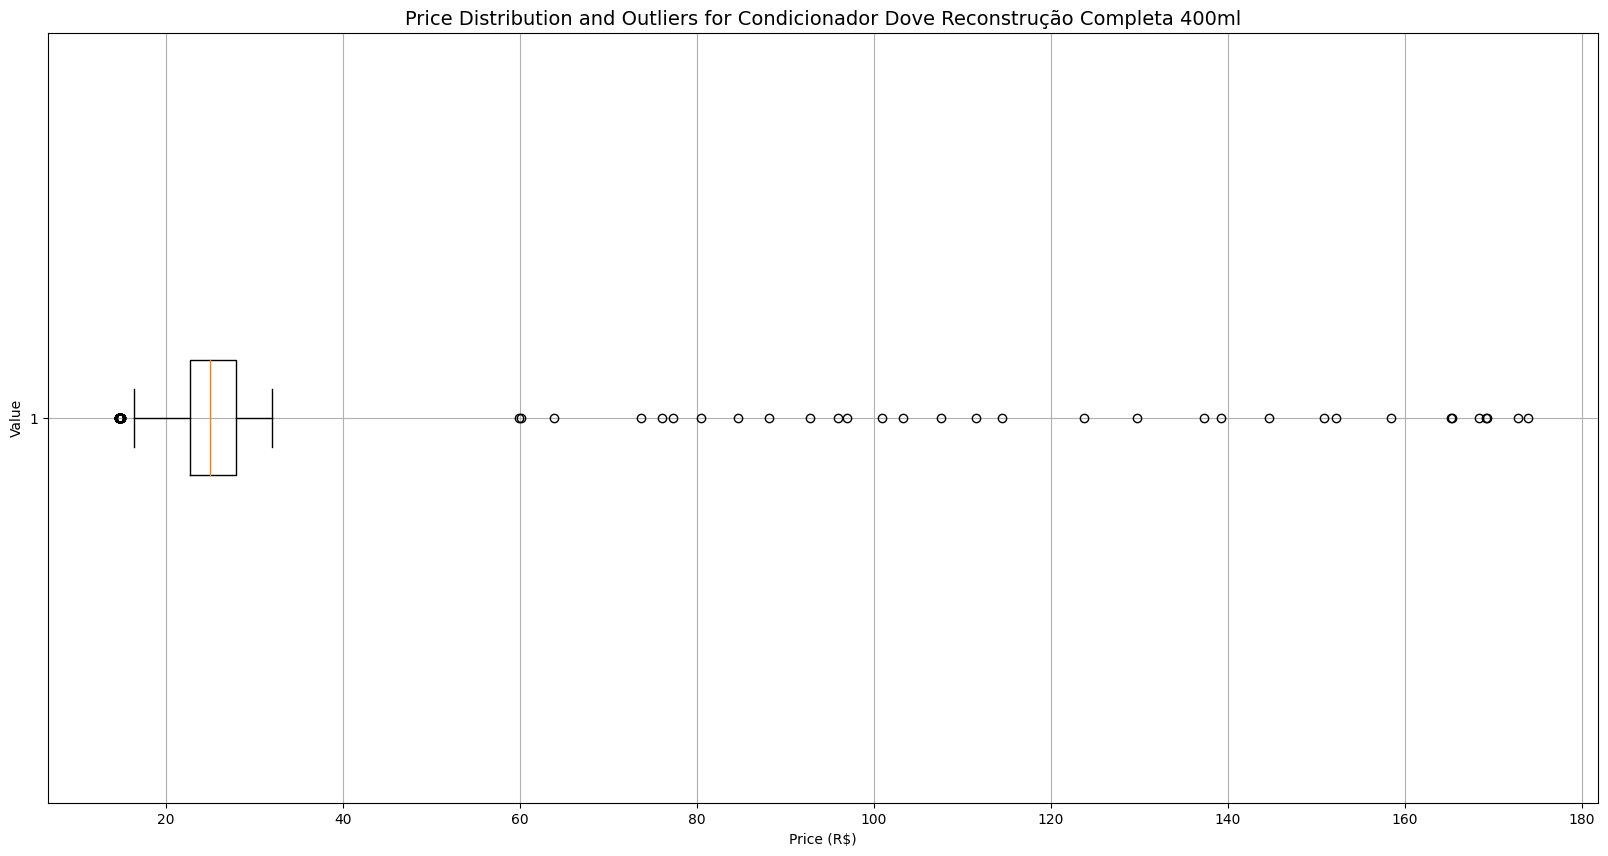

Price Descriptive Statistics (R$):
Mean: 31.86
Median: 24.99
Standard Deviation: 28.5
Min: 14.69
Max: 173.85

Outliers:
21      77.33
37     152.23
43     103.29
50      84.68
53      97.01
61      88.10
90     139.18
92      73.66
93     165.33
105    158.36
112    114.50
121    169.29
139    111.52
144    169.12
146     95.98
174    137.31
176    129.68
181    123.74
188    173.85
210    100.90
233    150.88
246    165.18
252    168.36
274    172.78
327    144.67
328     80.51
334     60.18
342     14.92
344     14.92
346     14.92
348     14.92
350     59.89
351     14.69
352     14.92
353     14.69
354     14.92
355     14.69
365     92.82
366     63.92
368     14.69
369     76.06
370     14.69
372     14.69
374     14.69
376     14.69
378     14.69
379    107.61
380     14.69
382     14.69
384     14.69
dtype: float64


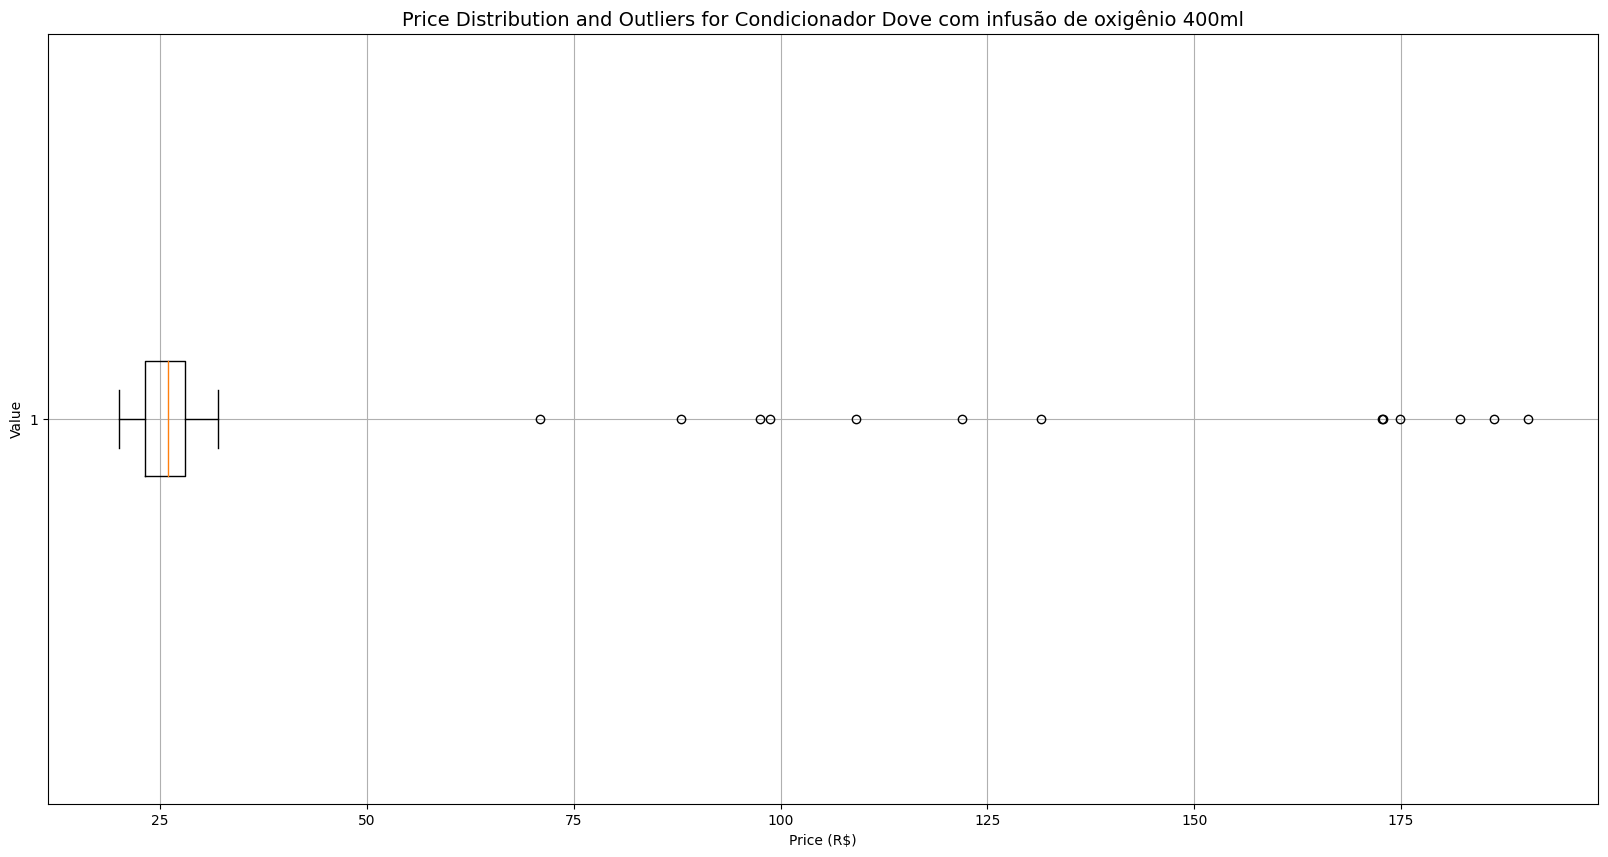

Price Descriptive Statistics (R$):
Mean: 35.58
Median: 25.99
Standard Deviation: 35.1
Min: 19.99
Max: 190.31

Outliers:
9       98.75
15     190.31
19     121.90
38     131.44
58      87.97
73     109.18
75      97.54
81     182.18
117    174.84
118     70.90
124    172.72
135    186.22
141    172.87
dtype: float64


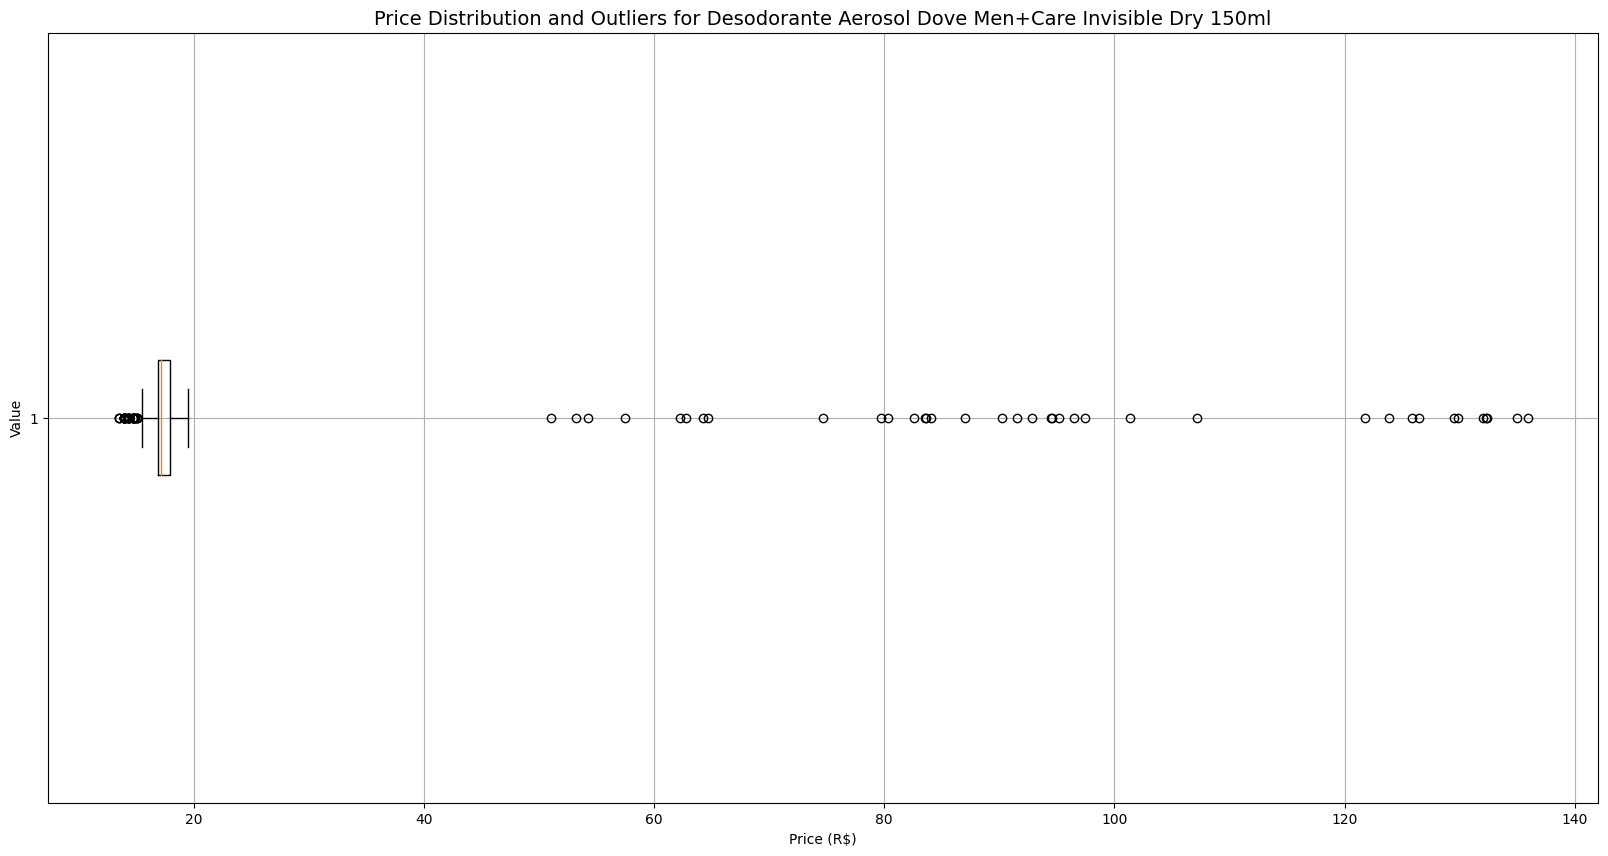

Price Descriptive Statistics (R$):
Mean: 24.44
Median: 17.13
Standard Deviation: 24.17
Min: 13.49
Max: 135.9

Outliers:
7      14.79
8      14.79
9      14.79
10     15.10
11     79.71
       ...  
355    13.98
358    64.24
375    62.30
377    80.36
386    14.00
Length: 75, dtype: float64


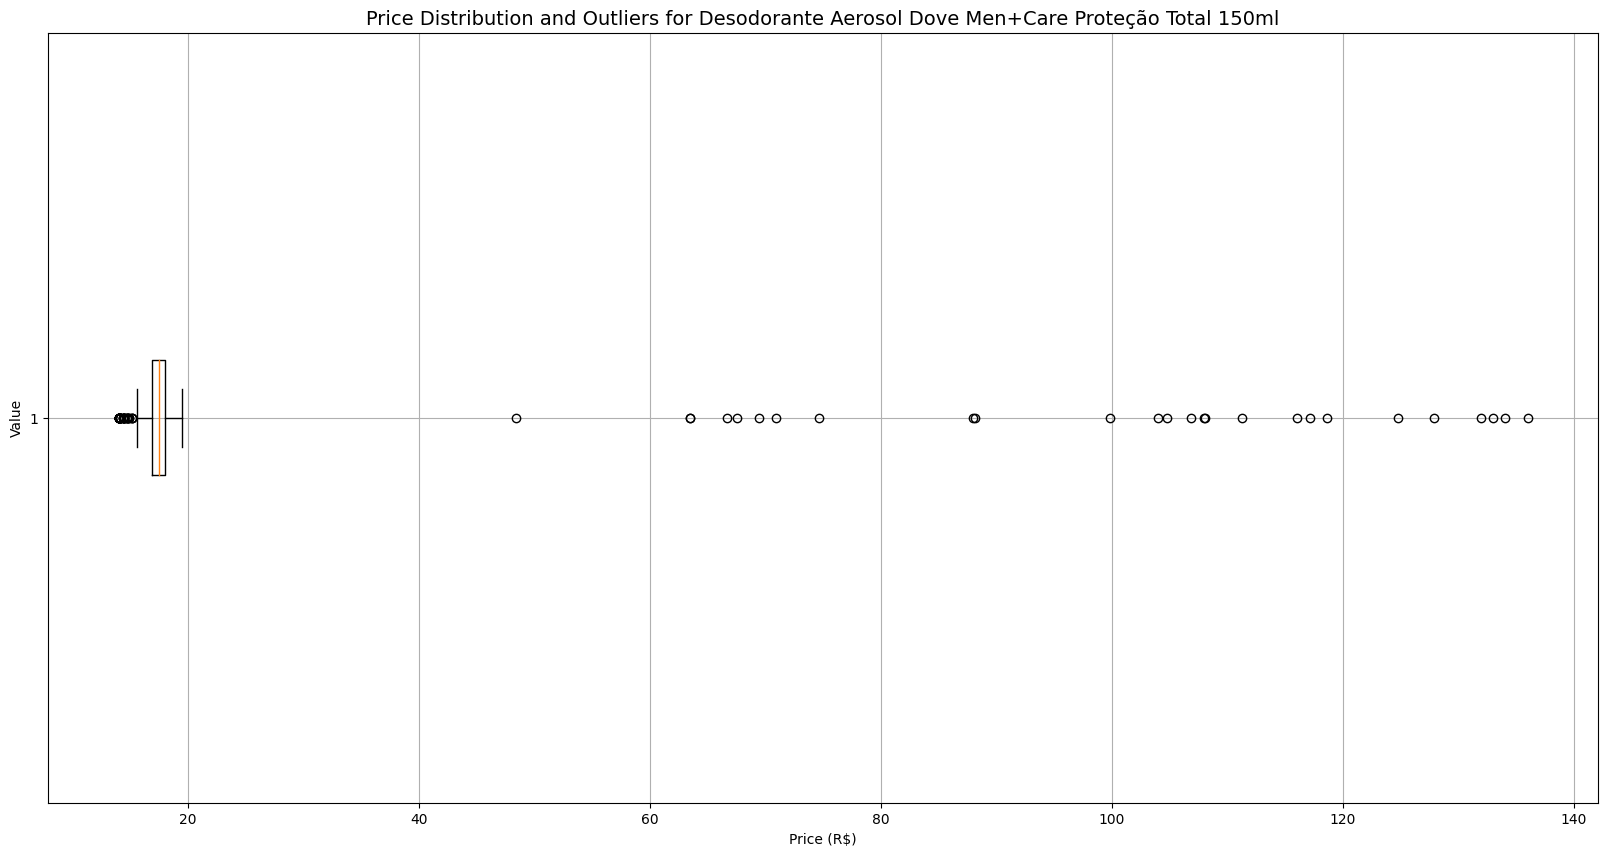

Price Descriptive Statistics (R$):
Mean: 25.09
Median: 17.52
Standard Deviation: 25.83
Min: 13.98
Max: 136.0

Outliers:
0       13.99
1       13.99
2       13.99
7       15.10
8       15.10
        ...  
200     14.43
225     13.98
239    131.95
252    111.24
255     14.00
Length: 67, dtype: float64


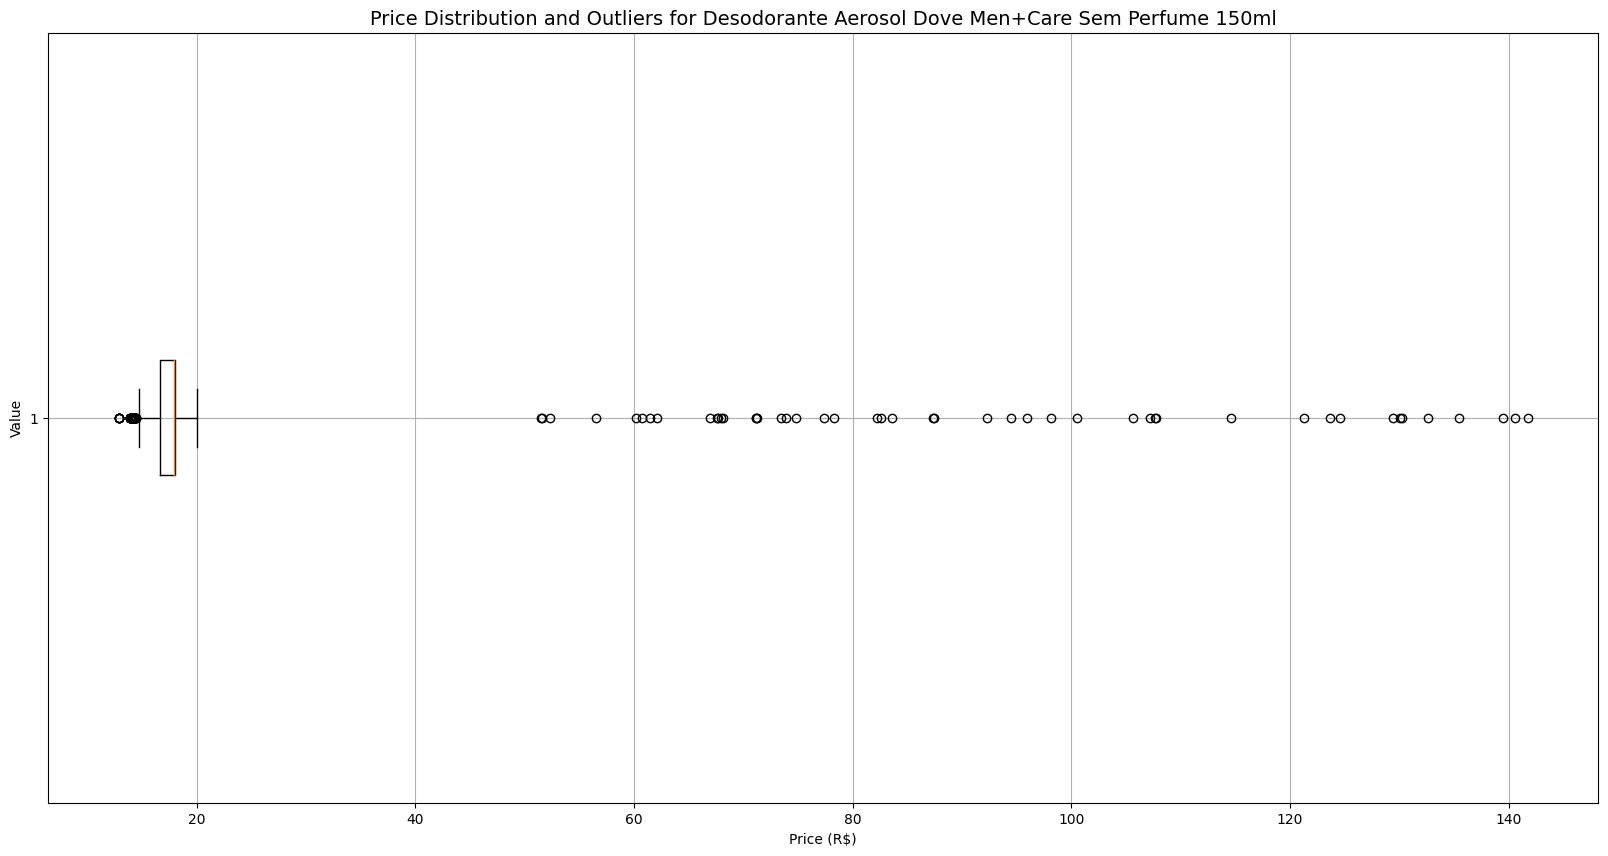

Price Descriptive Statistics (R$):
Mean: 23.31
Median: 17.9
Standard Deviation: 22.06
Min: 12.85
Max: 141.75

Outliers:
0       92.30
3       61.49
5       13.99
7       13.99
9       13.99
        ...  
494     62.09
496     14.00
515     82.63
516    140.55
542    141.75
Length: 113, dtype: float64


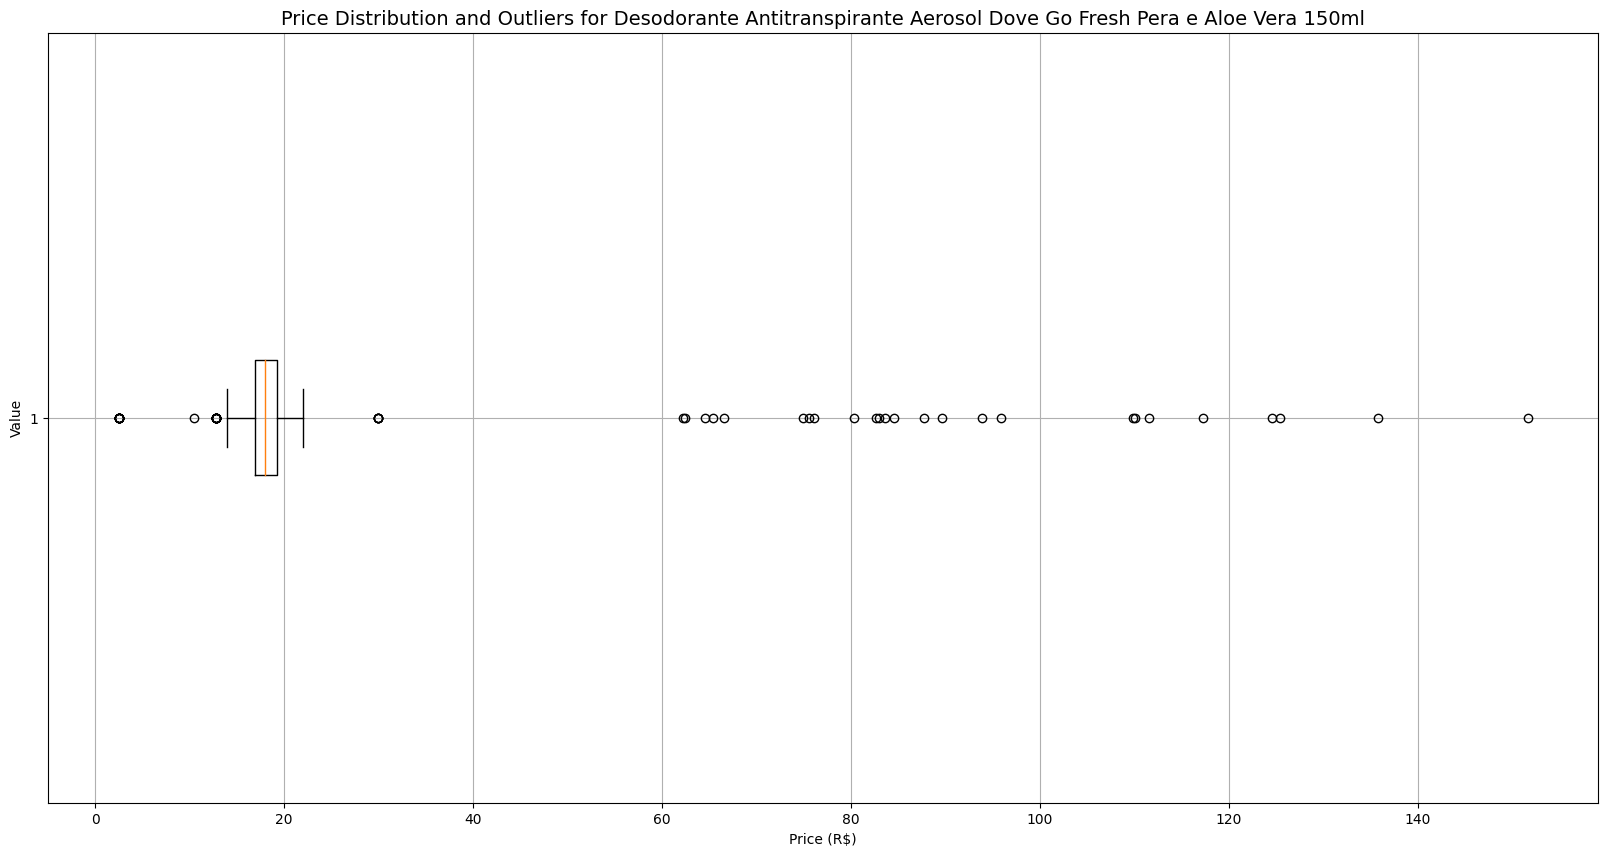

Price Descriptive Statistics (R$):
Mean: 22.72
Median: 17.99
Standard Deviation: 20.9
Min: 2.49
Max: 151.6

Outliers:
27      80.36
35      12.79
37      12.79
39      12.79
41      12.79
43      12.79
45      12.79
46      12.79
47      12.79
48      12.79
49      12.79
50      12.79
51      12.79
52      12.79
54      74.88
56      12.79
67     125.43
88      75.55
89      82.98
118    151.60
121    135.71
128     95.87
145     65.43
147    111.51
149     66.60
169    110.02
180    124.49
191    117.26
202     29.99
203     29.99
205     29.99
207     29.99
209     29.99
218      2.49
220     10.51
222      2.49
224      2.49
226      2.49
230      2.49
231     64.49
232      2.49
234      2.49
236      2.49
237     93.90
238      2.49
240      2.49
241      2.49
250     62.40
254     62.20
255     76.11
258     82.60
266    109.84
300     84.56
313     87.68
316     83.58
319     89.60
dtype: float64


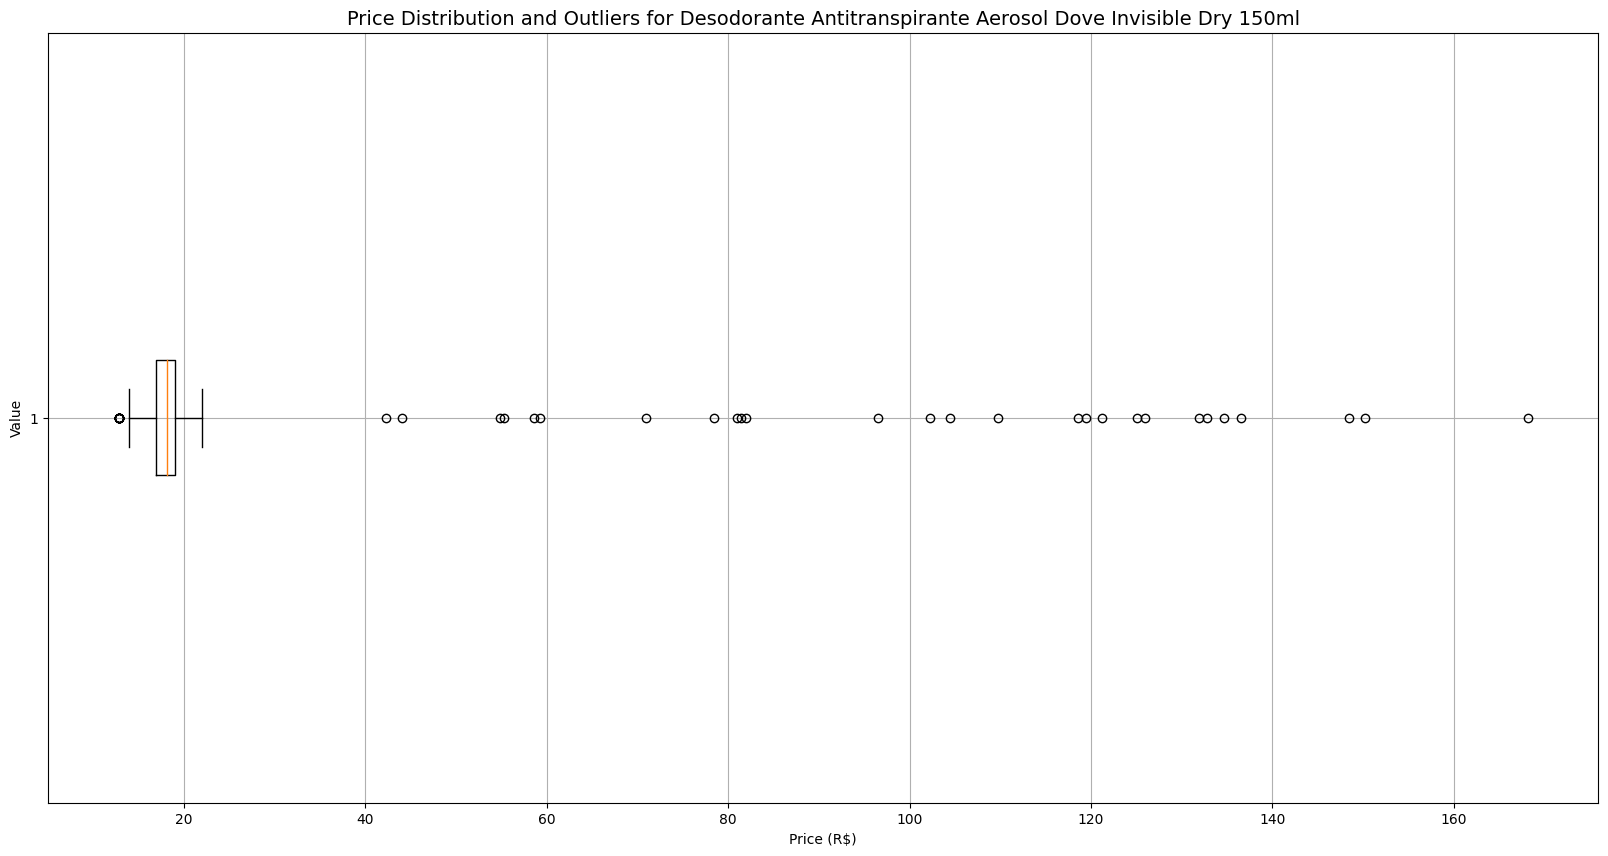

Price Descriptive Statistics (R$):
Mean: 22.64
Median: 18.17
Standard Deviation: 21.8
Min: 12.79
Max: 168.16

Outliers:
2       44.06
40     132.80
46      12.79
48      12.79
50      12.79
52      12.79
54      12.79
56      12.79
58      12.79
60      54.84
62      12.79
66      12.79
67     118.54
68      12.79
70      12.79
71      12.79
72      12.79
92     102.26
116     81.37
132     96.49
133    131.97
148     78.40
153     82.02
181    150.24
205    119.42
215    121.22
282     70.91
288    109.76
305    136.54
309     55.30
318     58.61
323    104.45
339    126.01
346     42.24
347    168.16
365    148.42
375    125.09
432     59.30
433     80.96
442    134.68
dtype: float64


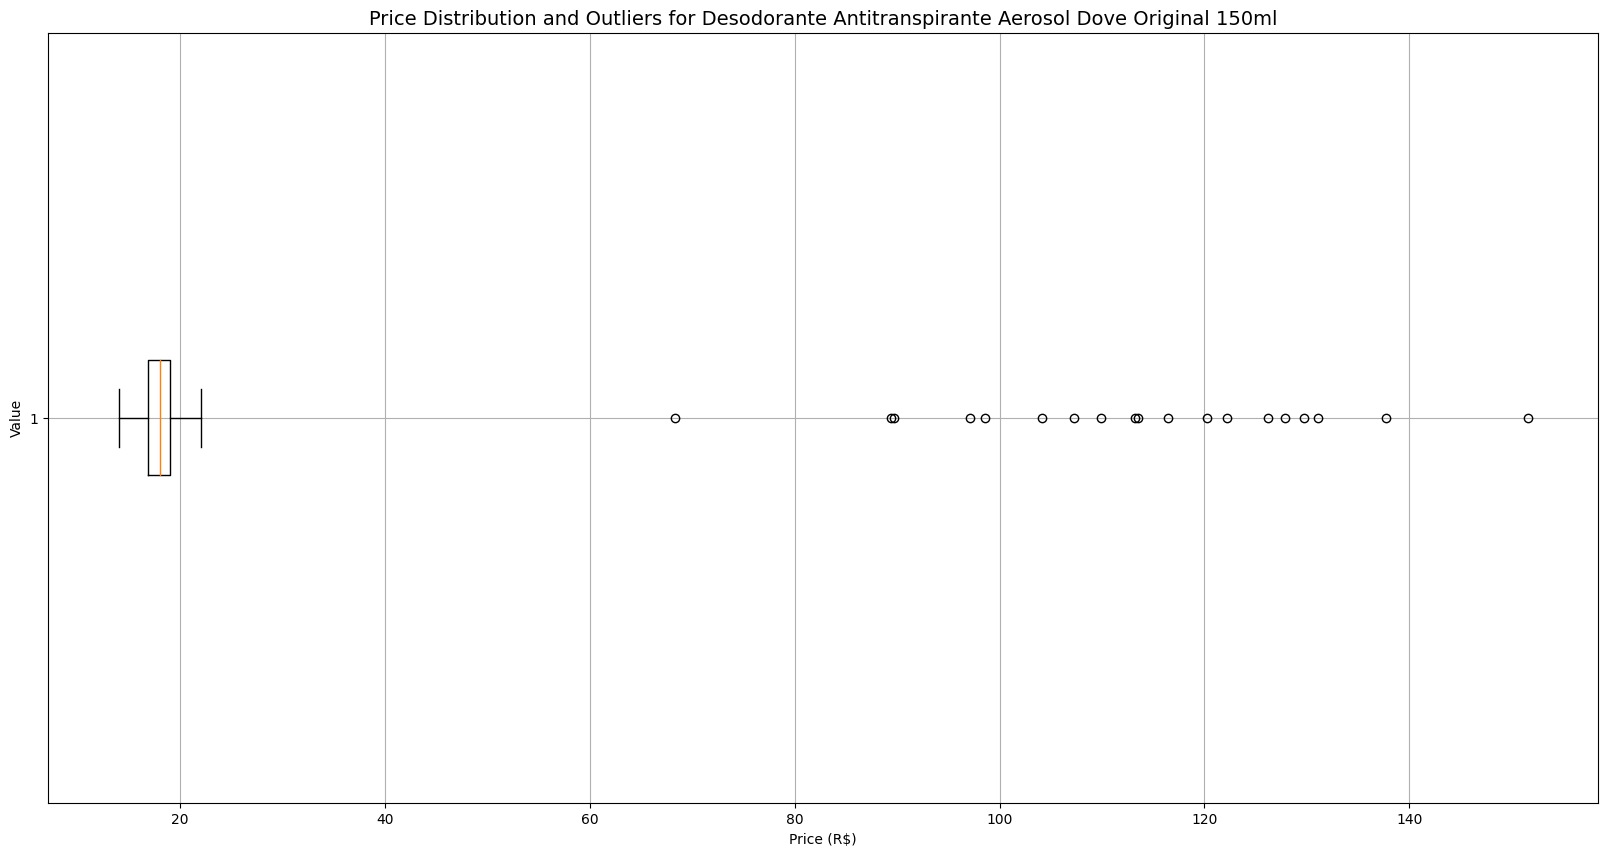

Price Descriptive Statistics (R$):
Mean: 25.06
Median: 17.99
Standard Deviation: 25.92
Min: 13.99
Max: 151.57

Outliers:
2      126.21
6       89.65
13      68.33
22     109.87
23     131.13
36     127.92
74     113.24
75     116.41
83     104.14
109    107.30
115     89.41
133     98.56
134    129.68
137     97.09
168    151.57
175    113.53
207    137.70
230    120.27
233    122.20
dtype: float64


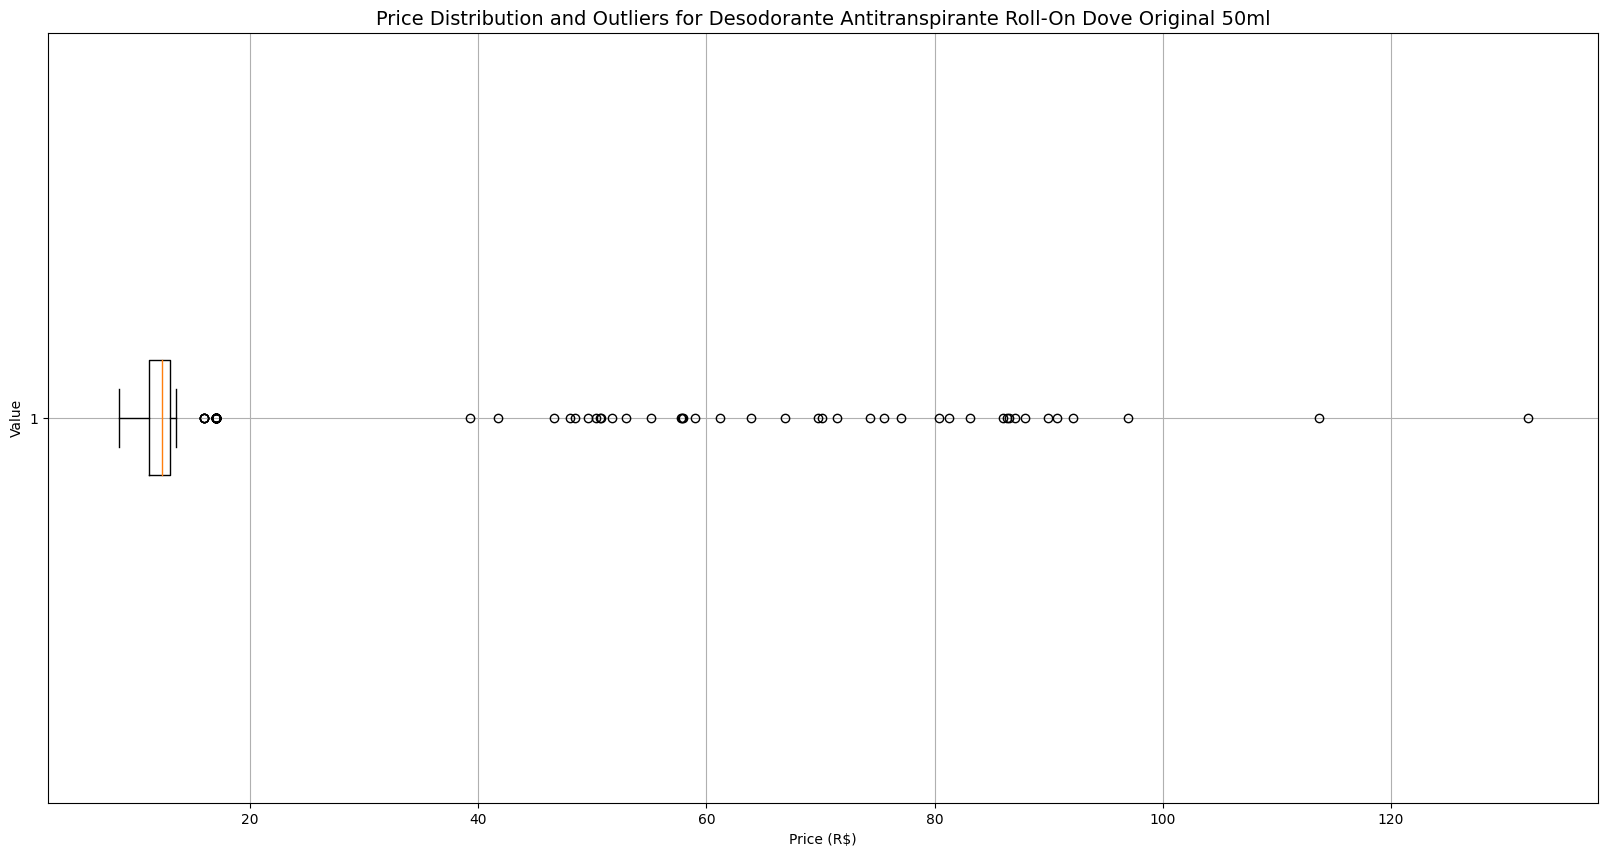

Price Descriptive Statistics (R$):
Mean: 17.46
Median: 12.25
Standard Deviation: 17.21
Min: 8.49
Max: 131.97

Outliers:
5      80.39
43     96.95
66     69.77
82     50.75
86     74.35
       ...  
409    16.99
410    16.99
411    16.99
412    16.99
431    77.09
Length: 84, dtype: float64


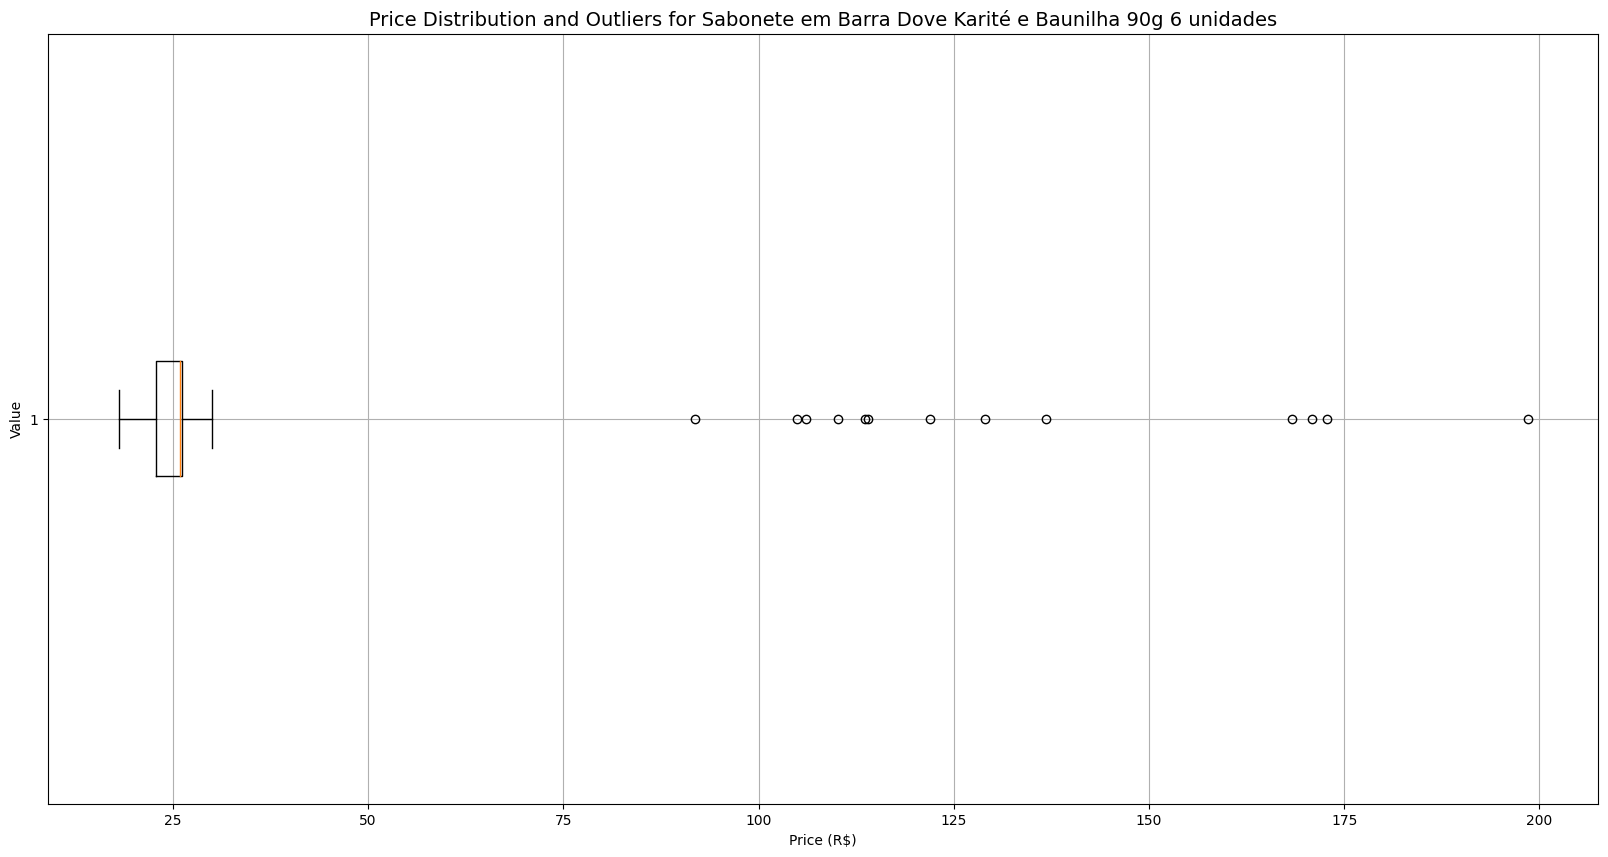

Price Descriptive Statistics (R$):
Mean: 31.87
Median: 25.9
Standard Deviation: 28.11
Min: 18.06
Max: 198.49

Outliers:
12     121.98
28     110.12
29     104.88
36     113.61
47     168.37
48      91.88
63     136.85
69     129.00
74     198.49
85     172.74
96     170.87
140    106.05
147    114.00
dtype: float64


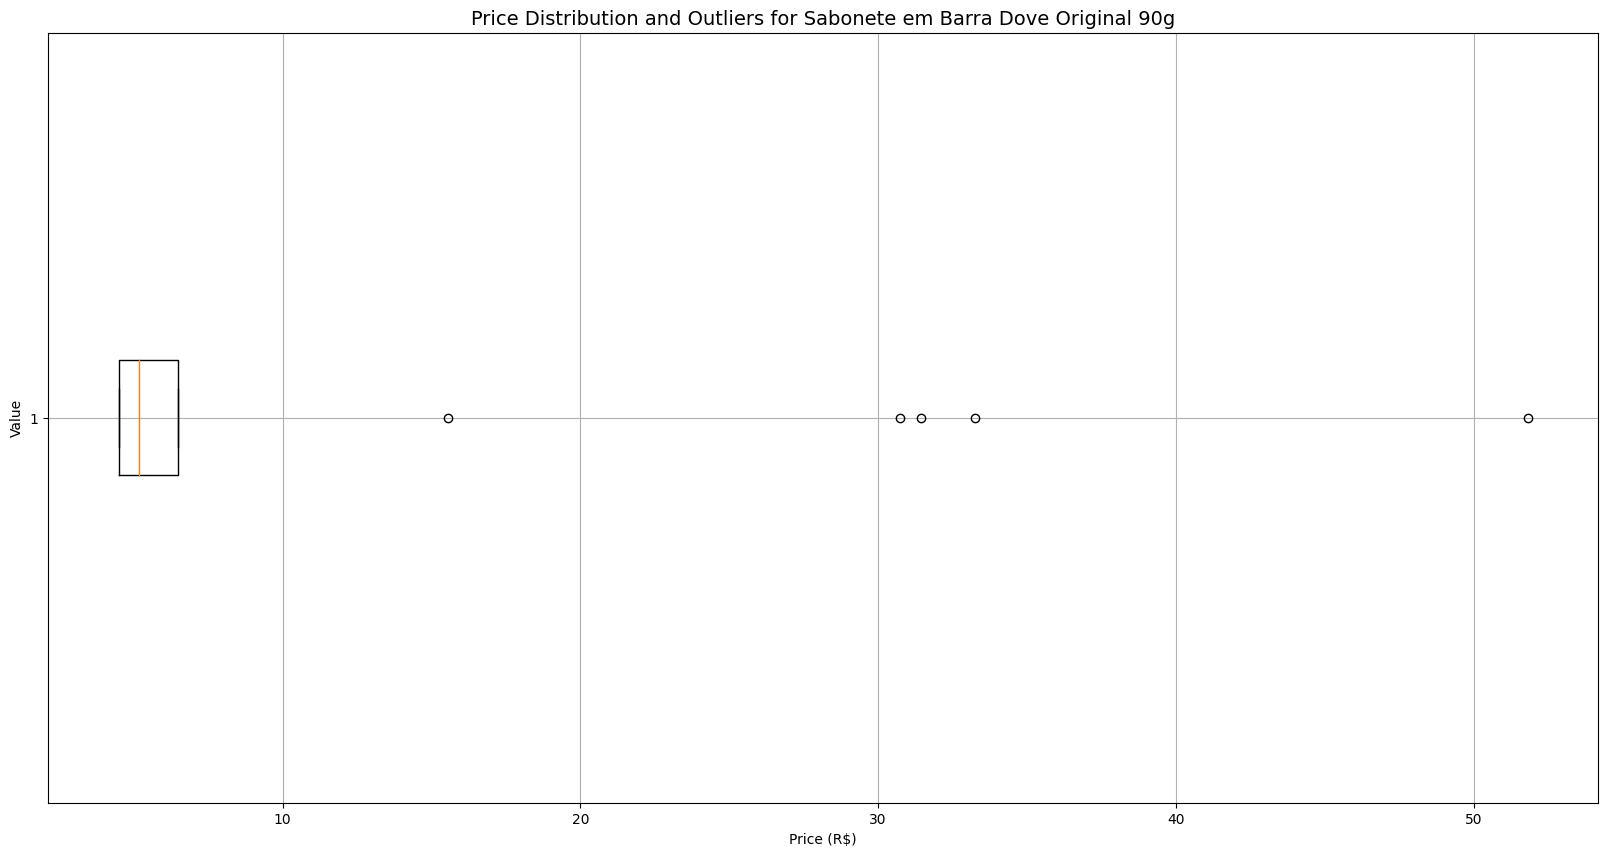

Price Descriptive Statistics (R$):
Mean: 6.91
Median: 5.19
Standard Deviation: 7.27
Min: 4.49
Max: 51.82

Outliers:
5     51.82
24    31.44
39    33.27
42    15.56
60    30.72
dtype: float64


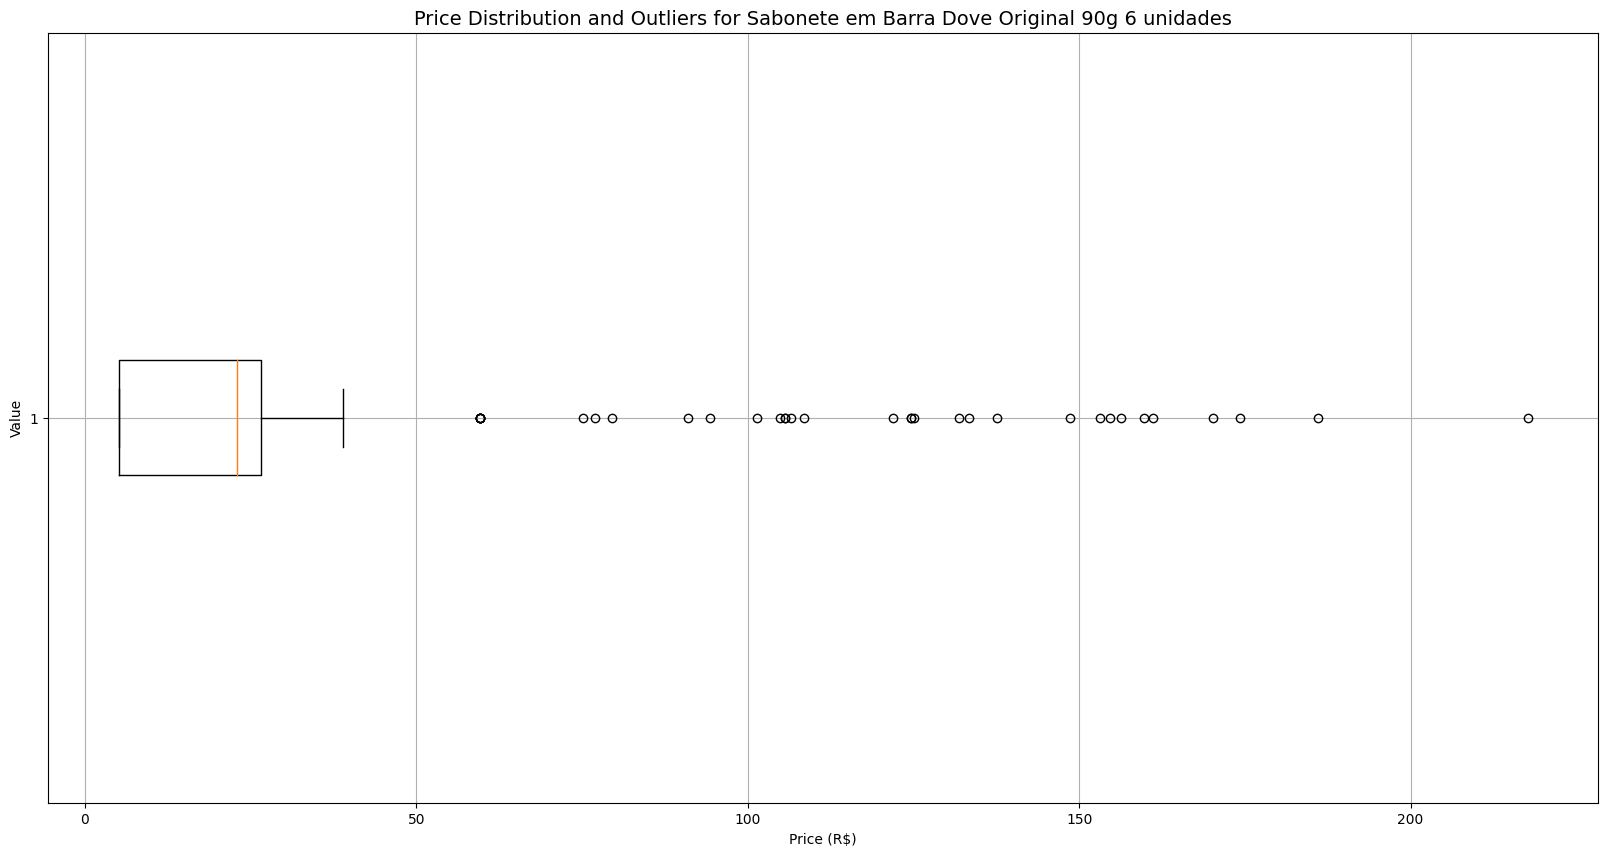

Price Descriptive Statistics (R$):
Mean: 27.26
Median: 22.9
Standard Deviation: 30.55
Min: 5.1
Max: 217.67

Outliers:
5      106.53
6      186.05
7      108.55
15      94.30
16     174.29
17     124.66
22     148.69
54      76.91
81     159.75
92     153.22
93     101.40
96     105.63
105    217.67
111    161.19
129    170.16
148    133.41
175    156.29
181     91.07
202    104.81
213    125.14
257    131.86
280    124.69
296     79.56
309     59.65
311     59.65
313     59.65
315     59.65
317     59.65
318    154.59
320     59.65
324    137.63
349    121.86
369     75.19
370    105.57
dtype: float64


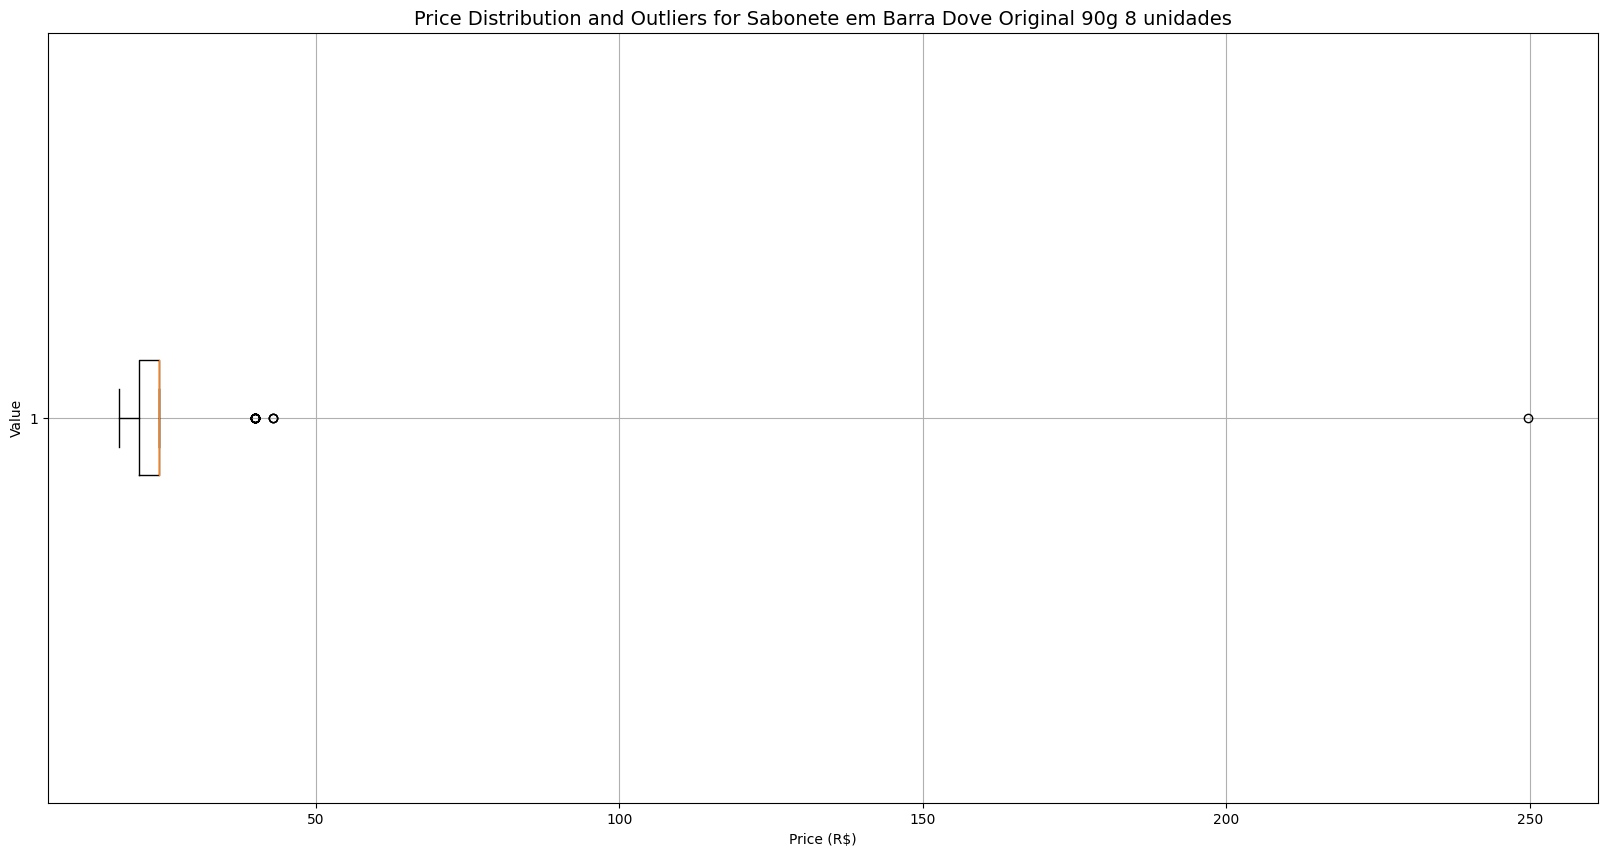

Price Descriptive Statistics (R$):
Mean: 26.44
Median: 24.15
Standard Deviation: 19.91
Min: 17.49
Max: 249.65

Outliers:
61     39.90
62     39.90
63     39.90
64     39.90
65     39.90
68     39.90
69     39.90
70     39.90
71     39.90
73     39.90
74     39.90
76     39.90
78     39.90
80     42.87
82     42.87
83     39.90
84     42.87
85    249.65
86     39.90
87     39.90
dtype: float64


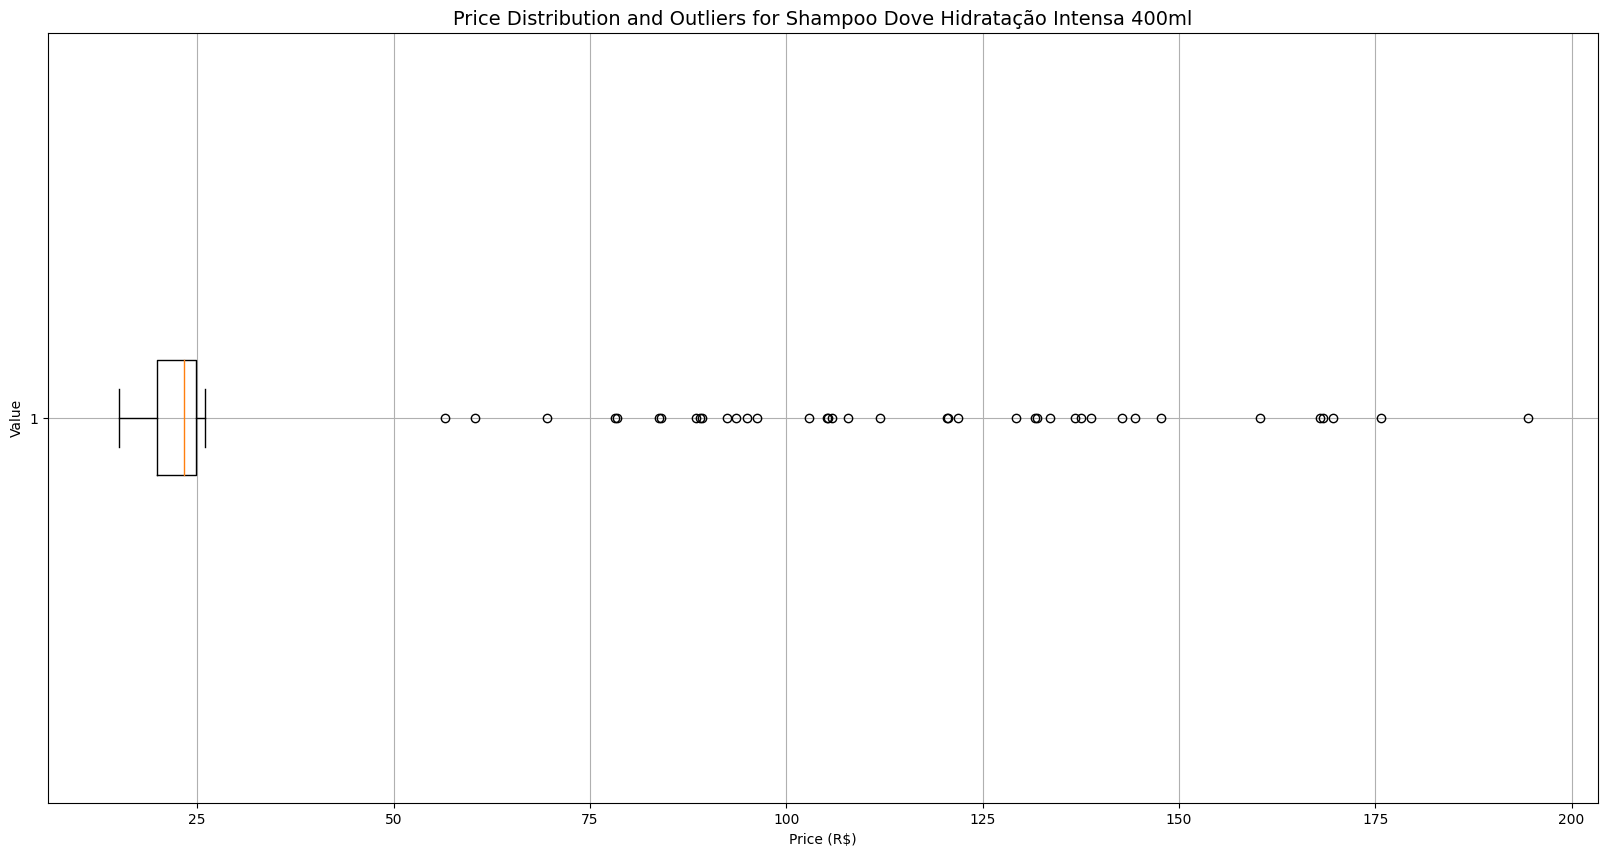

Price Descriptive Statistics (R$):
Mean: 29.06
Median: 23.33
Standard Deviation: 26.93
Min: 14.99
Max: 194.42

Outliers:
5      105.19
7       56.61
12      69.56
78      96.23
94     136.75
107    120.48
111     88.52
129    175.69
139    107.87
141    142.73
145    169.57
150     78.48
161     89.07
168     93.57
173    129.27
176    144.42
193    194.42
196     84.01
220    120.66
223    133.62
229    105.31
232    131.65
260    121.92
264    102.84
268     60.42
272     89.29
276    131.91
278    137.50
289    111.91
319    167.96
333    168.36
348    160.35
353     92.47
356     83.83
364    147.70
367     95.03
397    105.87
407    138.86
411     78.22
dtype: float64


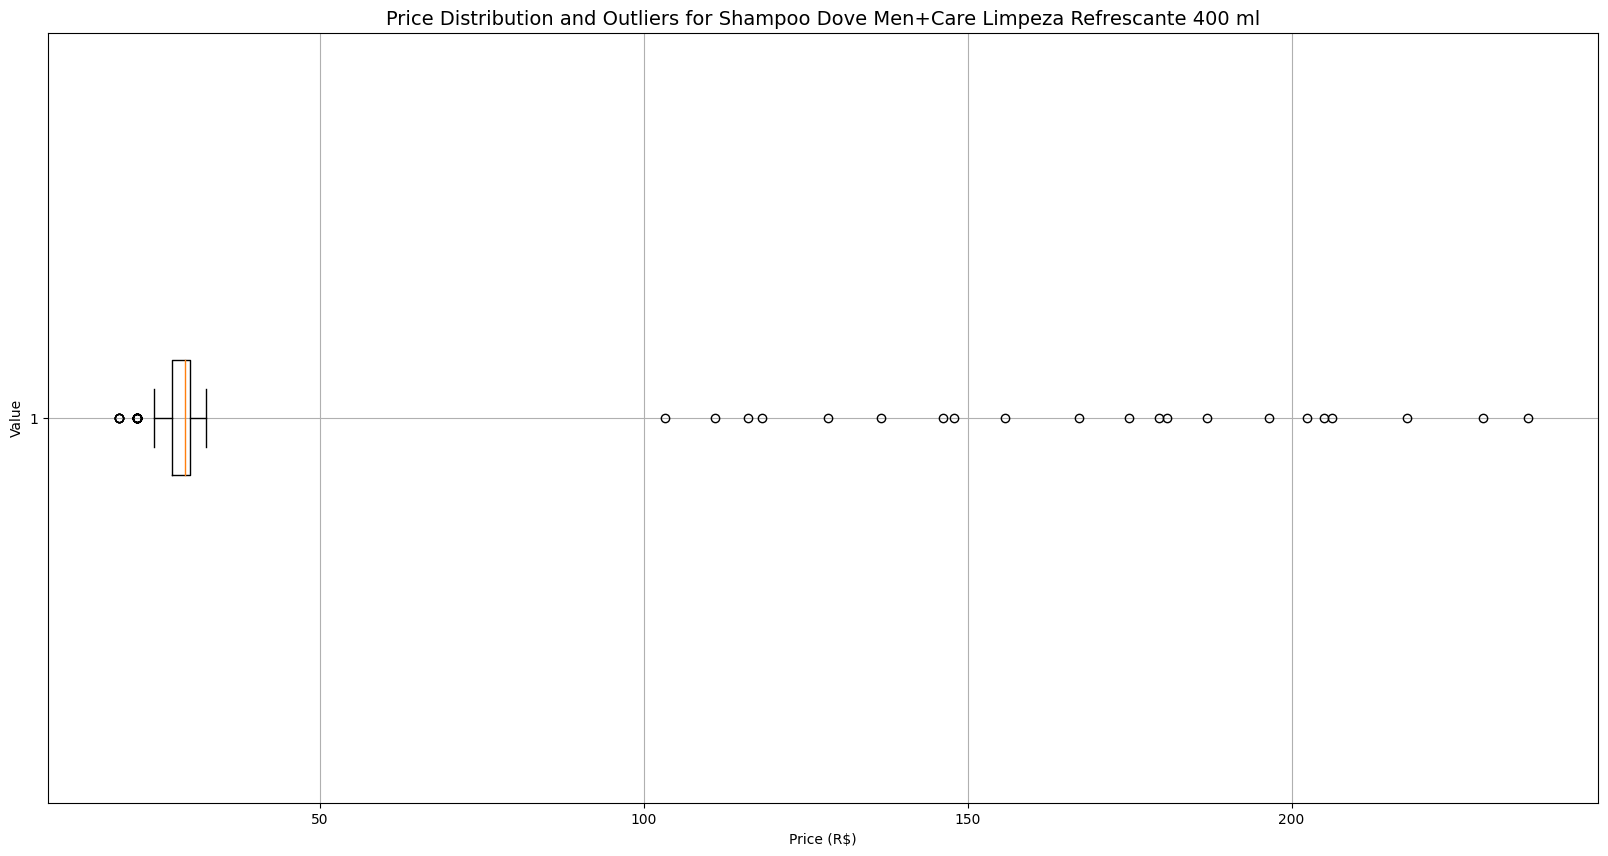

Price Descriptive Statistics (R$):
Mean: 39.85
Median: 29.19
Standard Deviation: 40.91
Min: 18.99
Max: 236.43

Outliers:
1       21.89
3       21.89
5      103.26
14     205.02
18      21.89
19      21.89
23     186.97
24     136.69
28     110.98
32     206.20
33     180.84
72     202.44
85     217.83
91     196.44
92     179.59
101    236.43
103    147.92
105    155.77
107    229.56
113    174.85
155     21.89
156     21.89
161     21.89
163     21.89
165    167.23
167     21.89
169    146.27
171     21.89
173     21.89
175     21.89
177     21.89
179     21.89
181     21.89
183     21.89
187     21.89
196     21.89
198     21.89
199    128.46
200     21.89
202    116.06
203     18.99
204     18.99
205     18.99
206     18.99
210     18.99
240    118.32
dtype: float64


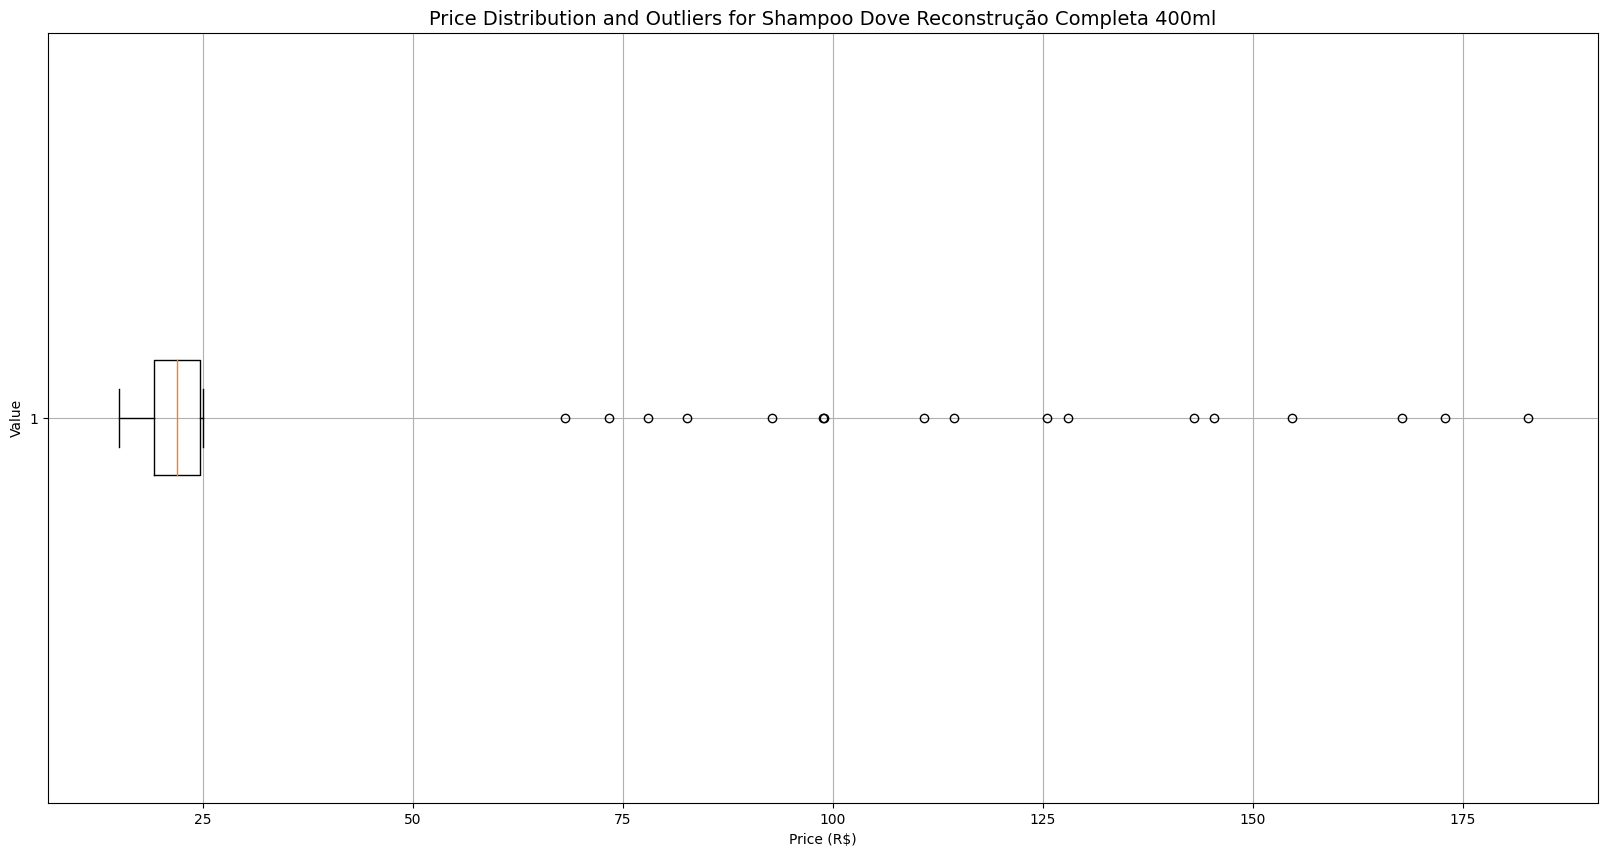

Price Descriptive Statistics (R$):
Mean: 27.68
Median: 21.94
Standard Deviation: 26.39
Min: 14.99
Max: 182.71

Outliers:
44     128.05
45      99.01
51     110.87
74     142.95
75     182.71
108    125.53
118     98.89
131    145.41
133     92.77
134    154.70
149     68.10
188     82.62
196    114.45
197    167.70
211     78.01
245     73.41
247    172.87
dtype: float64


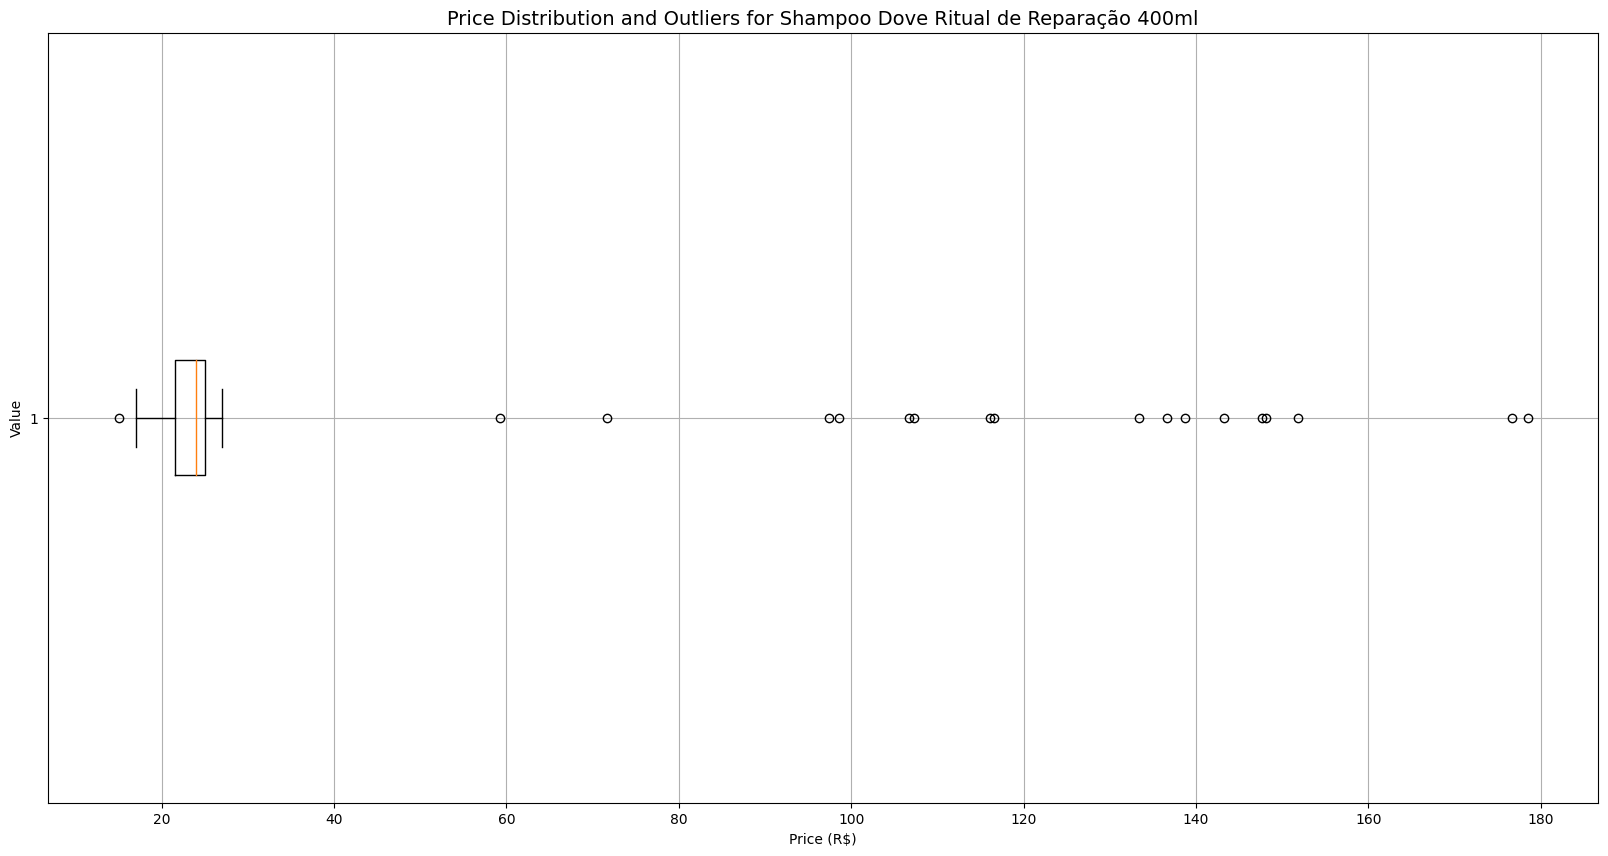

Price Descriptive Statistics (R$):
Mean: 34.78
Median: 23.99
Standard Deviation: 35.22
Min: 14.99
Max: 178.5

Outliers:
5      176.71
6      136.59
11     133.44
12     143.22
16     107.33
19     151.88
30      59.29
31     116.11
36     116.58
39     148.09
51     106.67
69     138.70
70     147.71
74     178.50
90      14.99
108     71.63
114     97.40
115     98.58
dtype: float64


In [6]:
# Customer Price Analysis
selected_customer = 'Unilever'
selected_brand = 'Dove'
selected_retailers = ['Amazon', 'DrogaRaia', 'Drogasil', 'Mercado Livre']

df_join3 = df_prod.merge(right = df_coletas, how='inner',\
                        on = 'MasterKey_RetailerProduct').groupby(\
                                                                ['Customer','Specifics', 'Competitor', 'Product',
                                                                'Brand','EAN','Retailer','MasterKey_RetailerProduct',
                                                                'DateIns'])['FinalPrice','SuggestedPrice'].mean()


df_join3['FinalPrice'] = np.round(df_join3['FinalPrice'].values,decimals = 2)
df_join3.reset_index(inplace = True)

df_selected = df_join3[(df_join3['Customer'] == selected_customer)&
                                (df_join3['Brand'] == selected_brand)&
                                (df_join3['Competitor'] == 0)]


for ean in pd.unique(df_selected['EAN']):
    df_ean = df_selected[df_selected['EAN'] == ean]
    label = str(pd.unique(df_selected[df_selected['EAN'] == ean]['Product'])).replace("['","").replace("']","")
    descriptive_stats(df_ean["FinalPrice"].values, label)